In [34]:
import requests
import pandas as pd
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
%matplotlib inline

font_dirs = ['./font'] # 폰트경로
font_files = fm.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    fm.fontManager.addfont(font_file)
plt.rcParams['font.family'] = 'Noto Sans CJK KR'
%config InlineBackend.figure_format = 'retina'

In [2]:
df = pd.read_csv('언론사_코드_매핑.csv')

In [3]:
# 진보 (라고 하는 언론사)
left_media_query = (df['언론사']=='한겨레')| (df['언론사']=='경향신문' ) #| (df['언론사']=='프레시안') | (df['언론사']=='오마이뉴스') | (df['언론사']=='머니투데이') | ( df['언론사']=='이데일리')  
df[left_media_query]

,언론사,코드
0,경향신문,1032
13,한겨레,1028


In [4]:
# 보수( 라고 하는 언론사)
right_media_query =    (df['언론사']=='조선일보') |(df['언론사']=='중앙일보')| (df['언론사']=='동아일보') | (df['언론사']=='문화일보' ) | (df['언론사']=='국민일보')# | ( df['언론사']=='뉴데일리')  
df[right_media_query]

,언론사,코드
1,국민일보,1005
3,동아일보,1020
5,문화일보,1021
10,조선일보,1023
11,중앙일보,1025


In [5]:
# 중도 (라고 하는 언론사)
middle_media_query = (df['언론사']=='서울신문') | (df['언론사']=='한국일보')  | (df['언론사']=='천지일보')# | (df['언론사']=='뉴시스' )# | (df['언론사']=='국민일보') | ( df['언론사']=='뉴데일리')  
df[middle_media_query]

,언론사,코드
6,서울신문,1081
12,천지일보,2041
14,한국일보,1469


In [6]:
def update_xpath():
    xpath_dict = {
        '경향신문':'//p[@class="content_text"]/text()',
        '한겨레':'//div[@class="text"]/text()',
        '국민일보':'//div[@id="articleBody"]/text()',
        '동아일보':'//div[@class="article_txt"]/text()',
        '문화일보':'//div[@id="NewsAdContent"]/text()',
        '중앙일보':'//div[@id="article_body"]/text()',
        '서울신문':'//div[@itemprop="articleBody"]/text()',
        '천지일보':'//div[@itemprop="articleBody"]/p/text()',
        '한국일보':'//div[@itemprop="articleBody"]/p/text()'
    }
    return xpath_dict

In [7]:
xpath_dict = update_xpath()

In [8]:
from tqdm.notebook import tqdm
from lxml import html
import time

In [ ]:
headers={
    'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.93 Safari/537.36',
    'Connection': 'keep-alive'
}
df_list = [
    df[left_media_query], 
   df[right_media_query],
   df[middle_media_query]

result = {}
for idx, idf in tqdm(enumerate(df_list)):
    
    for i in idf['언론사']:
        result[str(i)+'|제목'] = []
        result[str(i)+'|본문'] = []

    for i, ipress in idf.iterrows():
        for i in tqdm(range(1,1000,10)):
            url ='https://search.naver.com/search.naver?where=news&sm=tab_pge&query="사설+정부&sort=0&photo=0&field=0&pd=0&ds=&de=&cluster_rank=11&mynews=1&office_type=1&office_section_code=1&news_office_checked={press_code}&nso=so:r,p:all,a:all&start={offset}'.format(press_code=ipress['코드'],offset=i)
            response = requests.get(url)
            tree = html.fromstring(response.text)
            if len(tree.xpath('//div[@class="news_area"]/a/@title')):
                result[ipress['언론사']+'|제목']+= tree.xpath('//div[@class="news_area"]/a/@title')
                #print(len(result[ipress['언론사']+'|제목']))
                for iurl in tree.xpath('//div[@class="news_area"]/a/@href'):
                    res = requests.get(iurl, headers=headers)
                    if res.status_code != 200:
                        result[ipress['언론사']+'|본문'].append(None)
                    else:
                        try:
                            root = html.fromstring(res.content.decode('CP949'))
                        except Exception:
                            root = html.fromstring(res.text)
                        #print(iurl)
                        if ipress['언론사'] == '조선일보': # javascript 내에 데이터 존재
                            start = int([i for i in root.xpath('//script')][-2].xpath('./text()')[0].find("content_element"))
                            p = re.compile(',"type":"text"}')
                            end = int([[m.start(),m.end()] for m in p.finditer([i for i in root.xpath('//script')][-2].xpath('./text()')[0])][-1][1])
                            result_ = json.loads([i for i in root.xpath('//script')][-2].xpath('./text()')[0][start+18:end]+']')
                            
                            article_text = ''.join([i['content'] for i in result_ if i['type']=="text"])
                        else:
                            article_text = ''.join([i.strip() for i in root.xpath(xpath_dict[ipress['언론사']])])

                        result[ipress['언론사']+'|본문'].append(article_text)
            else:
                break
            time.sleep(0.01)
        print(ipress['언론사'],'개수\t',len(result[ipress['언론사']+'|제목']))
        if len(result[ipress['언론사']+'|제목']) != 1000:
            result[ipress['언론사']+'|제목']+=['' for j in range(1000-len(result[ipress['언론사']+'|제목']))]
            result[ipress['언론사']+'|본문']+=['' for j in range(1000-len(result[ipress['언론사']+'|제목']))]

    # result를 csv 로 저장

In [9]:
df_left = pd.read_csv('media_left.csv')
df_right = pd.read_csv('media_right.csv')
df_middle = pd.read_csv('media_middle.csv')

In [10]:
df_left.head()

,경향신문|제목,경향신문|본문,한겨레|제목,한겨레|본문
0,"[사설]지주회사체제 중심 LH 혁신안, 해체 수준 개혁 맞나",정부가 한국토지주택공사(LH) 최종 혁신안을 당정 협의가 끝나는 대로 내놓는다고 한...,"[사설] 4대 그룹 미국 투자, 국내 고용 위축 최소화해야",국내 4대 그룹이 미국에 394억달러(약 44조원)를 투자하겠다고 지난 21일 발표...
1,[사설]피부에 와닿는 유인책으로 백신 접종에 박차 가해야,정부는 오는 11월 집단면역을 달성하기 위해 상반기 목표를 1300만명 1차 접종으...,[사설] ‘북핵 협상’ 재개 위한 공은 모두의 코트에 있다,문재인 대통령과 조 바이든 대통령이 남북 판문점 선언과 북-미 싱가포르 공동성명 등...
2,[사설] 차기 정부로 미룬 교육부의 대학 구조조정 방안 유감스럽다,교육부가 20일 위기에 처한 대학 구조조정의 큰 그림인 ‘대학의 체계적 관리 및 혁...,[사설] 판문점·싱가포르 합의 토대로 ‘대북 대화’ 뜻 모은 한미 정상,문재인 대통령과 조 바이든 미국 대통령이 21일(현지시각) 미국 백악관에서 정상회담...
3,"[사설]한·미 동맹 강화, 한·중관계 훼손으로 이어져선 안 된다",지난 주말 열린 한·미 정상회담 후 채택된 공동성명에 대만 문제가 포함된 것을 놓고...,[사설] 새로운 기회와 도전이 될 한미동맹 ‘글로벌’ 격상,문재인 대통령이 미국 워싱턴에서 한-미 정상회담을 마치고 23일 귀국했다. 문 대통...
4,[사설]백신 허브·감염병 선진국 초석 다진 한·미의 ‘코로나 공조’,한·미 양국이 정상회담을 통해 포괄적인 ‘글로벌 백신 파트너십’ 구축에 합의했다. ...,"[사설] 한-미 백신·경제 협력, 가시적 성과로 이어지길",문재인 대통령과 조 바이든 미국 대통령은 한-미 정상회담에서 ‘글로벌 백신 파트너십...


In [11]:
df_right.head()

,국민일보|제목,국민일보|본문,동아일보|제목,동아일보|본문,문화일보|제목,문화일보|본문,조선일보|제목,조선일보|본문,중앙일보|제목,중앙일보|본문
0,"[사설] 검찰 조직 개편, 국가 수사 역량 훼손되지 않게 신중해야",법무부의 검찰 조직개편 추진에 우려의 목소리가 나온다. 검수완박(검찰 수사권 완전 ...,[사설]미성년자에 부모 빚 상속시켜 억대 빚쟁이 만드는 현행법,물려받은 빚을 감당하지 못해 개인파산을 신청한 미성년자가 2016년부터 올해 3월까...,<사설>韓美훈련 재개와 전단법 폐기가 동맹 정상화 시금석,문재인-조 바이든 첫 정상회담의 돋보이는 성과 중 하나가 북한 인권에 대한 인식 공...,"[사설] 탈원전하면서 “美와 원전 협력”, 이 모순을 설명해보라",문재인 대통령이 바이든 미 대통령과 회담에서 해외 원전 수출 시장에 한·미가 공동 ...,[사설] 권력형 비리 덮기 위해 검찰 수사 막는 건가,박범계 법무부 장관이 추진하는 ‘검찰청 조직개편안’이 검찰의 직접수사권을 통제하기 ...
1,[사설] 미국과의 백신 파트너십으로 국내 공급난 해소되길,한·미가 ‘글로벌 백신 파트너십’을 구축하기로 한 것은 이번 한·미 정상회담의 핵심...,"[사설]2주 새 시총 1100조 증발한 코인, 붕괴 가능성도 대비할 때",가상화폐 시장이 혼란에 빠져들고 있다. 코인 종류를 가리지 않고 연일 폭락하면서 글...,<사설>대만·원전·6G 협력…親中遠美(친중원미) 4년 바로잡을 때다,미국 백악관에서 지난 21일 열린 한·미 정상회담의 공동성명은 예상을 뛰어넘을 정도...,[사설] 탈원전 오류 인정하는 것이 국정 정상화 첫걸음,정부가 원전 해외 수출을 위해 미국과 협력하겠다고 한 것은 사실상 탈원전 정책의 문...,"[사설] 아쉬움 남는 백신 외교, 공급 차질 없게 만전 기해야",문재인 대통령과 조 바이든 미국 대통령의 첫 한·미 정상회담에서 큰 기대를 모았던 ...
2,[사설] 매물 안 내놓는다고 임대사업자 혜택 뺏겠다는 정부,"다주택자에 대한 양도소득세 중과 시행(6월 1일)이 불과 일주일 앞으로 다가왔지만,...","[사설]中, 한미 정상회담에 반발… 원칙외교로 당당히 대응하라","중국 외교부는 어제 정례 브리핑에서 한미 정상회담 공동성명에 대만해협, 남중국해 등...",<사설>이젠 탄소중립 내세워 울창한 山林 망치는 탈원전 폐해,민둥산을 반 세기도 안 돼 울창한 산림(山林)으로 만든 대한민국의 산림녹화 성공도 ...,"[사설] 북핵 원칙, 한미 훈련, 사드 정상화하고 전단법은 폐기해야","이번 정상회담에서 한미는 북한 핵과 인권, 중국 문제, 미사일 지침, 경제 협력 등...","[사설] 한·미 동맹 강화 재확인한 정상회담, 실천으로 이어지길",기대 반 우려 반 속에 열린 한·미 정상회담이 막을 내렸다. 이번 회담의 가장 큰 ...
3,"[사설] 북, 미국의 거듭된 대화 의지에 화답할 차례",핵 문제 해결을 위한 미국의 대북 유화 제스처가 연일 이어지고 있다. 토니 블링컨 ...,"[사설]檢 수사기능 더 줄이려는 朴법무, 또 증권합수단 전철 밟나",박범계 법무부 장관이 검찰의 직접 수사 기능을 더욱 축소하는 방향의 조직 개편에 착...,"마두로 정권, 정부 비판 유력 일간지 건물 압류",니콜라스 마두로 베네수엘라 정권이 정권 2인자에 대한 명예훼손 손해배상 집행을 내세...,"[사설] ‘미사일·쿼드·기술’ 합의, 한미 동맹 정상화의 출발 되길",한미 정상회담에서 문재인 대통령은 미북 대화가 ‘판문점과 싱가포르 선언 등을 기초로...,[사설] 무주택 서민을 허탈하게 한 공무원들의 ‘특공 재테크’,세종시 이전 기관 공무원에게 우선권을 주는 아파트 특별공급(특공)의 문제점이 잇따라...
4,[사설] 성공적인 한·미 정상회담… 후속 조치에 만전 기해야,문재인 대통령과 조 바이든 미국 대통령의 정상회담이 성공적으로 끝났다. 3박5일간 ...,[사설]새 대북특사 임명하면서 南에 ‘서둘지 말라’ 주문한 바이든,문재인 대통령과 조 바이든 미 대통령은 21일 공동성명에서 “2018년 판문점 선언...,"<사설>용두사미 與 부동산 대책, 국민 고통·혼선 더 키운다",민심을 수용하겠다며 요란하게 시작했던 여당의 부동산 대책이 결국 일부 구간의 재산세...,"[사설] 허언으로 끝난 백신 스와프, ‘국군 55만명분’에 감읍할 때인가",한미 정상회담의 성과 중 하나로 정부는 ‘글로벌 백신 파트너십’ 합의를 내세웠다. ...,[사설] 중국에 고객 정보 통째로 내준 애플…우리는 안전한가,애플이 중국 정부에 아이폰 고객 정보를 통째로 넘겨 사전 검열·감시에 적극 협조했다...


In [12]:
df_middle.head()

,서울신문|제목,서울신문|본문,천지일보|제목,천지일보|본문,한국일보|제목,한국일보|본문
0,"[사설] 미사일 주권, 자주국방 완성으로 이어져야",미국이 사실상 한국에 강제해 온 ‘미사일 지침’이 폐기됐다. 그제 미국 백악관에서 ...,[천지일보 사설] 文대통령 방미 성과는 자화자찬?,미국을 방문 중인 문재인 대통령이 21일(현지시간) 백악관에서 바이든 미국 대통령과...,[사설] 무늬만 'LH 혁신안’ 부패 근절되겠나,한국토지주택공사(LH) 혁신안이 이르면 27일 발표될 것으로 알려졌다. 애초 김부겸...
1,"[사설] 60~74세 예약률 56%, 백신 접종 유인책 서둘러야",코로나19 백신은 일시적 수급 불균형에서 벗어나 정상화 추세에 접어들었다. 한미 정...,[천지일보 사설] 토지초과이득세를 고민하자,서울 아파트값이 15주 만에 0.1%대 상승률을 기록하며 다시 불안감을 키우고 있다...,"[사설] 중국 과도한 반응, 한중 신뢰 관계에 도움 안돼","중국은 한미가 정상회담 공동성명에서 대만 문제를 언급한 것이 내정간섭이며, 용납할 ..."
2,[사설] 미국 블링컨 장관 대화 제의에 북한은 응답하라,토니 블링컨 미국 국무장관이 현지시간 23일 “한반도 비핵화 목표를 달성하기 위한 ...,[천지일보 사설] 박준영 사퇴로 끝낼 일이 아니다,박준영 해양수산부 장관 후보자가 13일 입장문을 내고 자진 사퇴했다. 박 후보자는 ...,[사설] '백신 스와프' 대신 '백신 허브' 더 의미 있다,한미 정상이 전 세계적으로 부족한 코로나19 백신 공급 확대를 위해 ‘한미 글로벌 ...
3,[사설] 고위공무원 ‘특공’으로 생긴 불로소득 반납은 어떤가,서울신문이 어제자로 보도한 고위공직자들의 ‘세종시 특별공급(특공) 재산 보유’ 실태...,"[천지일보 사설] 정부, 독감백신 포비아 해소방안 조속히 제시해야",이쯤 되면 독감백신 포비아(공포증)가 생기는 게 당연하다. 지난 16일 인천 17세...,"[사설] 사드 배치 후 첫 민관군협의회, 갈등 푸는 계기로",국방부가 24일 고고도 미사일 방어체계(THAADㆍ사드)기지를 둘러싼 갈등을 해소하...
4,[사설] 백신·안보·경제 망라한 한미 정상회담 성과,문재인 대통령이 한미 정상회담 등 방미 일정을 마치고 귀국했다. 코로나19 위기와 ...,"[천지일보 사설] 정부, 국민‧인권‧북한 중 무엇이 가장 중한가",국민이 북한군에 피살당하고 화형까지 당했다면 강력 항의하고 합당한 대응도 하는 게 ...,[사설] 북에 유연한 태도 보인 바이든... 김정은 호응해야,문재인 대통령과 조 바이든 미국 대통령이 21일 첫 정상회담에서 외교를 통한 북핵 ...


In [13]:
import MeCab, re

In [14]:
mecab =MeCab.Tagger()

In [18]:
def parse_text(text):
    bucket = []
    start = 0
    pattern = re.compile(".*\t[A-Z]+") 
    for token, pos in  [tuple(pattern.match(token).group(0).split("\t")) for token in mecab.parse(text).splitlines()[:-1]]:
        if start == 0:
            lspace = False
        elif text[start] == ' ':
            lspace = True
        else:
            lspace = False
        start = text.find(token, start)
        end = start + len(token)
        bucket.append((token, pos, lspace, start, end))
        start = end
    return bucket
def apply_noun_ext(df): 
    for key,val in df.to_dict().items():
        if key.split('|')[-1] == '제목':
            title = val
        else:
            content = val
    text = title+content
    clean_text = re.sub('\[사설\]|\[논평\]|\[칼럼\]\[의견\]\[단독\]', '', text)
    result = noun_ext(parse_text(clean_text))
    return result

def check_noun(cand):
    if len(re.findall('[^가-힣a-zA-Z0-9+]', cand)) > 0:
        return False
    else:
        return True
def noun_ext(parsed_text):
    global stopwords
    global one_list
    noun_bucket = []
    bi_bucket = []
    tri_bucket = []
    last_last_add = None
    last_add = None
    last_lspace = None
    for ichunk in parsed_text:
        token = ichunk[0]
        pos = ichunk[1]
        lspace = ichunk[2]
        add = False
        if pos == 'NNG': 
            if check_noun(token) == True: 
                if token not in stopwords:
                    if len(token) > 1: 
                        add = True
                    elif token in one_list:
                        add = True
        if pos == 'NNP': 
            if token not in stopwords:
                if len(token) > 1:
                    add = True
                elif token in one_list:
                    add = True
                    
        if add == True:
            if (last_add == True) and (lspace == False) and (len(noun_bucket) > 0):
                bi_bucket.append('|'.join([noun_bucket[-1], token]))
            if (last_add == True) and (last_last_add == True) and (lspace == False) and \
            (last_lspace == False) and (len(noun_bucket) > 1):
                tri_bucket.append('|'.join([noun_bucket[-2], noun_bucket[-1], token]))
            noun_bucket.append(token)
        last_lspace = lspace
        last_last_add = last_add
        last_add = add
    return pd.Series((noun_bucket, bi_bucket, tri_bucket))

In [19]:
one_list = list('젤펄물향색립손짱굳양톤물티밤코빛붓굿돈팩맥맛감웜집샵끈선속밖겉봄반광팁샷솔볼폼딥입펜발템갑값'
            '똥룩꿀떡존몸핏땀핫옆꽃액칠금쿨차밥병솜망폰링통옷목팔숱배살털컬홈짝뷰')

In [20]:
df_all = pd.concat([df_left, df_right, df_middle], axis=1)

In [21]:
stopwords = ['정부','기자','배포','무단','전재','코로나','한국','대통령','문제','장관','상황']
result_df = []
for i in tqdm(range(0,len(df_all.columns),2)):
    df = pd.DataFrame()
    df[['keywords','bigrams','trigrams']] = df_all[df_all.columns[i:i+2]].fillna('').apply(apply_noun_ext, axis=1)
    result_df.append(df)

  0%|          | 0/10 [00:00<?, ?it/s]

In [22]:
df_left_analysis = pd.concat([result_df[0],result_df[1]])
df_right_analysis = pd.concat([result_df[i] for i in range(2,7)])
df_middle_analysis = pd.concat([result_df[i] for i in range(7,10)])

In [23]:
from collections import Counter
df_analysis_list = [df_left_analysis, df_right_analysis, df_middle_analysis]
counter = list()
for idf in df_analysis_list:
    c = Counter()
    c_b = Counter()
    c_t = Counter()
    for i,row in idf.iterrows():
        keywords = row['keywords']
        bigrams = row['bigrams']
        trigrams = row['trigrams']
        c.update(keywords)
        c_b.update(bigrams)
        c_t.update(trigrams)
    counter.append([c.most_common(200), c_b.most_common(200),c_t.most_common(200)])
    #print(c.most_common(100), c_b.most_common(100),c_t.most_common(100),'\n')

####  진보 

In [24]:
pd.concat([pd.DataFrame(counter[0][i]) for i in range(3)], axis=1).head(30)

,0,1,0,1,0,1
0,국민,2206,남북|관계,323,경제|협력|개발,59
1,정책,1885,국제|사회,235,협력|개발|기구,59
2,사회,1740,집단|감염,188,추가|경정|예산안,39
3,경제,1731,방역|당국,170,중앙|재난|안전대책본부,30
4,미국,1419,고용|보험,139,산업|안전|보건,22
5,필요,1350,미래|통합,136,남북|공동|연락사무소,19
6,대책,1319,공시|가격,125,고용|유지|지원금,18
7,북한,1300,택배|노동자,117,남북|교류|협력,18
8,방역,1293,검찰|개혁,105,에너지|기본|계획,15
9,국회,1250,구조|조정,97,대북|특별|대표,14


#### 보수

In [25]:
pd.concat([pd.DataFrame(counter[1][i]) for i in range(3)], axis=1).head(30)

,0,1,0,1,0,1
0,국민,5066,국제|사회,294,경제|협력|개발,81
1,북한,4022,공시|가격,272,협력|개발|기구,81
2,경제,3956,남북|관계,192,추가|경정|예산안,45
3,정책,3807,정상|회담,156,중앙|재난|안전대책본부,43
4,미국,3219,구조|조정,133,국가|안전|보장,36
5,기업,2872,경제|정책,122,주택|담보|대출,36
6,중국,2815,국가|채무,120,남북|공동|연락사무소,32
7,수사,2592,집단|감염,115,안전|보장|회의,31
8,국가,2307,미래|통합,107,국가|채무|비율,30
9,청와대,2206,집단|면역,102,관리|재정|수지,29


#### 중도

In [26]:
pd.concat([pd.DataFrame(counter[2][i]) for i in range(3)], axis=1).head(30)

,0,1,0,1,0,1
0,국민,4621,집단|감염,241,경제|협력|개발,54
1,경제,2928,국제|사회,238,협력|개발|기구,54
2,국회,2621,임시|국회,207,중앙|재난|안전대책본부,42
3,정책,2181,정상|회담,183,미사일|방어|체계,38
4,미국,2142,남북|관계,156,추가|경정|예산안,36
5,북한,2068,검찰|개혁,153,국회|선진|화법,29
6,사회,2041,미래|통합,147,고용|유지|지원금,28
7,정치,1933,경제|정책,144,비상|경제|회의,27
8,일본,1726,정기|국회,130,남북|공동|연락사무소,26
9,이번,1692,국정|감사,122,강제|개종|교육,23


### 개체명 사전을 위한 작업

In [27]:
# 개체명 사전 bigram trigram
df_ner = pd.read_csv('개체명사전.csv')
df_ner['품사']='고유명사'
df_ner[['품사','토큰']]

,품사,토큰
0,고유명사,미래통합당
1,고유명사,경제협력개발기구
2,고유명사,중앙재난안전대책본부
3,고유명사,보건의료단체
4,고유명사,종합병원
...,...,...
331,고유명사,비서실장
332,고유명사,삼성서울병원
333,고유명사,정책실장
334,고유명사,민정수석비서관


In [28]:
import os
import MeCab
mecab =MeCab.Tagger()

In [30]:
left_noun_df = pd.concat([pd.DataFrame(counter[0][i]) for i in range(3)], axis=1)
left_noun_df.columns=['noun','noun_cnt','bigram','bi_cnt','trigram','tri_cnt']
left_noun_df.head(10)

,noun,noun_cnt,bigram,bi_cnt,trigram,tri_cnt
0,국민,2206,남북|관계,323,경제|협력|개발,59
1,정책,1885,국제|사회,235,협력|개발|기구,59
2,사회,1740,집단|감염,188,추가|경정|예산안,39
3,경제,1731,방역|당국,170,중앙|재난|안전대책본부,30
4,미국,1419,고용|보험,139,산업|안전|보건,22
5,필요,1350,미래|통합,136,남북|공동|연락사무소,19
6,대책,1319,공시|가격,125,고용|유지|지원금,18
7,북한,1300,택배|노동자,117,남북|교류|협력,18
8,방역,1293,검찰|개혁,105,에너지|기본|계획,15
9,국회,1250,구조|조정,97,대북|특별|대표,14


In [31]:
right_noun_df = pd.concat([pd.DataFrame(counter[1][i]) for i in range(3)], axis=1)
right_noun_df.columns=['noun','noun_cnt','bigram','bi_cnt','trigram','tri_cnt']
right_noun_df.head(10)

,noun,noun_cnt,bigram,bi_cnt,trigram,tri_cnt
0,국민,5066,국제|사회,294,경제|협력|개발,81
1,북한,4022,공시|가격,272,협력|개발|기구,81
2,경제,3956,남북|관계,192,추가|경정|예산안,45
3,정책,3807,정상|회담,156,중앙|재난|안전대책본부,43
4,미국,3219,구조|조정,133,국가|안전|보장,36
5,기업,2872,경제|정책,122,주택|담보|대출,36
6,중국,2815,국가|채무,120,남북|공동|연락사무소,32
7,수사,2592,집단|감염,115,안전|보장|회의,31
8,국가,2307,미래|통합,107,국가|채무|비율,30
9,청와대,2206,집단|면역,102,관리|재정|수지,29


#### 나온 단어 기준 1-2 사이의 값으로 scaling

##### 진보 언론 키워드 점수 계산

In [32]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler((1,2))
fitted = min_max_scaler.fit(left_noun_df[['noun_cnt','bi_cnt','tri_cnt']])

output = min_max_scaler.transform(left_noun_df[['noun_cnt','bi_cnt','tri_cnt']])
output = pd.DataFrame(output, columns=['noun_cnt','bi_cnt','tri_cnt'], index=list(left_noun_df.index.values))
left_noun_df[['noun_cnt','bi_cnt','tri_cnt']] = output
left_noun_df

,noun,noun_cnt,bigram,bi_cnt,trigram,tri_cnt
0,국민,2.000000,남북|관계,2.000000,경제|협력|개발,2.000000
1,정책,1.827327,국제|사회,1.711475,협력|개발|기구,2.000000
2,사회,1.749328,집단|감염,1.557377,추가|경정|예산안,1.649123
3,경제,1.744486,방역|당국,1.498361,중앙|재난|안전대책본부,1.491228
4,미국,1.576654,고용|보험,1.396721,산업|안전|보건,1.350877
...,...,...,...,...,...,...
195,경기,1.002690,군사|행동,1.000000,동남아|국가|연합,1.000000
196,의사,1.001614,개발|이익,1.000000,특별|정상|회의,1.000000
197,판단,1.001076,불로|소득,1.000000,처분|가능|소득,1.000000
198,방식,1.000538,부동산|대책,1.000000,동아|태차|관보,1.000000


##### 보수 언론 키워드 점수 계산

In [33]:
min_max_scaler = MinMaxScaler((1,2))
fitted = min_max_scaler.fit(right_noun_df[['noun_cnt','bi_cnt','tri_cnt']])

output = min_max_scaler.transform(right_noun_df[['noun_cnt','bi_cnt','tri_cnt']])
output = pd.DataFrame(output, columns=['noun_cnt','bi_cnt','tri_cnt'], index=list(right_noun_df.index.values))
right_noun_df[['noun_cnt','bi_cnt','tri_cnt']] = output
right_noun_df

,noun,noun_cnt,bigram,bi_cnt,trigram,tri_cnt
0,국민,2.000000,국제|사회,2.000000,경제|협력|개발,2.000000
1,북한,1.767535,공시|가격,1.918216,협력|개발|기구,2.000000
2,경제,1.752839,남북|관계,1.620818,추가|경정|예산안,1.532468
3,정책,1.719662,정상|회담,1.486989,중앙|재난|안전대책본부,1.506494
4,미국,1.588733,구조|조정,1.401487,국가|안전|보장,1.415584
...,...,...,...,...,...,...
195,상태,1.000445,사회|안전망,1.000000,국가|과학|기술,1.000000
196,반,1.000223,금융|감독원,1.000000,입|법조|사관,1.000000
197,자유,1.000223,정보|기관,1.000000,국민|건강보험|공단,1.000000
198,핵심,1.000000,규제|지역,1.000000,공공기관|운영|위원회,1.000000


In [ ]:
left_noun_df

In [ ]:
# def average(d):
#     noun_avg=d['noun_cnt']/(200*1090.235)
#     bi_avg=d['bi_cnt']/(200*47.64)
#     tri_avg=d['tri_cnt']/(200*8.935)
#     return pd.Series((noun_avg, bi_avg, tri_avg))
# right_noun_df[['noun_cnt','bi_cnt','tri_cnt']]=right_noun_df.apply(average,axis=1)

In [ ]:
right_noun_df.head()

##### 진보/보수 계산을 하기 위한 키워드 기준 dict mapping 추출

In [39]:
calculate_left = dict()
calculate_right = dict()
for idx, row in left_noun_df.iterrows():
    noun,bigram,trigram = row['noun'],row['bigram'],row['trigram']
    calculate_left[noun]=row['noun_cnt']
    calculate_left[bigram]=row['bi_cnt']
    calculate_left[trigram]=row['tri_cnt']

    
for idx, row in right_noun_df.iterrows():
    noun,bigram,trigram = row['noun'],row['bigram'],row['trigram']
    calculate_right[noun]=row['noun_cnt']
    calculate_right[bigram]=row['bi_cnt']
    calculate_right[trigram]=row['tri_cnt']


In [43]:
def calculate_bias(d):
    """
    진보쪽에 나온 키워드들 점수 - subtract
    보수쪽에 나온 키워드들 점수 + add
    """
    global calculate_left
    global calculate_right
    keywords,bigrams,trigrams=d['keywords'], d['bigrams'],d['trigrams']
    left_point_noun, right_point_noun =0,0
    left_point_bi, right_point_bi =0,0
    left_point_tri, right_point_tri =0,0
    most_keyword = Counter()
    for keyword in keywords:
        if keyword in calculate_left.keys(): # 진보언론쪽 분석
            most_keyword.update([keyword])
            left_point_noun += calculate_left[keyword]
        if keyword in calculate_right.keys(): # 보수언론쪽 분석
            right_point_noun += calculate_right[keyword]
    for bigram in bigrams:
        if bigram in calculate_left.keys(): 
            left_point_bi += calculate_left[bigram]
        if bigram in calculate_right.keys(): 
            right_point_bi += calculate_right[bigram]
    for trigram in trigrams:
        if trigram in calculate_left.keys(): 
            left_point_tri += calculate_left[trigram]
        if trigram in calculate_right.keys(): 
            right_point_tri += calculate_right[trigram]
    most_string=''
   
    most_string+='|'.join([i[0] for i in most_keyword.most_common(3)])

    return pd.Series((most_string,left_point_noun, right_point_noun,
                          left_point_bi, right_point_bi,
                          left_point_tri, right_point_tri,
                          left_point_noun*(-1)+right_point_noun \
                          -left_point_bi+ right_point_bi \
                          -left_point_tri+right_point_tri
                         ))

#### 중도 사설 분석

In [65]:
tmp = df_middle_analysis.apply(calculate_bias,axis=1)
tmp.columns=['freq_keywords','진보|명사|점수','보수|명사|점수','진보|bi|점수','보수|bi|점수','진보|tri|점수','보수|tri|점수','합산']
tmp

,freq_keywords,진보|명사|점수,보수|명사|점수,진보|bi|점수,보수|bi|점수,진보|tri|점수,보수|tri|점수,합산
0,미국|개발|이번,49.716514,50.441772,2.308197,3.639405,0.000000,0.000000,2.056467
1,백신|접종|국민,96.285637,95.987531,4.537705,4.866171,0.000000,0.000000,0.030359
2,대화|북한|미국,95.756859,92.309508,3.914754,4.579926,0.000000,0.000000,-2.782179
3,주택|일부|이유,31.171060,34.847027,1.000000,0.000000,0.000000,0.000000,2.675968
4,백신|경제|정상,92.164605,93.916277,6.944262,7.754647,1.210526,0.000000,1.351531
...,...,...,...,...,...,...,...,...
995,수도|지역|정책,59.422808,53.301715,1.003279,1.011152,0.000000,1.012987,-5.100233
996,의원|위원장|민주당,57.090909,58.212202,0.000000,0.000000,0.000000,0.000000,1.121293
997,인사|개혁|제도,37.764389,32.369183,0.000000,0.000000,1.035088,1.077922,-5.352372
998,미국|지역|안전,50.444863,46.323759,3.734426,5.297398,2.421053,2.766234,-2.212952


In [66]:
tmp.describe()

,진보|명사|점수,보수|명사|점수,진보|bi|점수,보수|bi|점수,진보|tri|점수,보수|tri|점수,합산
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,63.180408,61.055473,2.556001,2.605404,0.384316,0.404026,-2.055822
std,24.196617,23.925280,3.139951,3.281429,1.064845,1.093014,8.546181
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-52.813418
25%,49.764793,47.400468,0.000000,0.000000,0.000000,0.000000,-6.803382
50%,63.186391,61.541082,1.386885,1.334572,0.000000,0.000000,-1.499904
75%,78.001748,75.607604,3.590164,3.670074,0.000000,0.000000,2.673282
max,228.332437,217.061456,22.895082,32.397770,12.421053,14.961039,32.260025


합산   -0.754571
dtype: float64


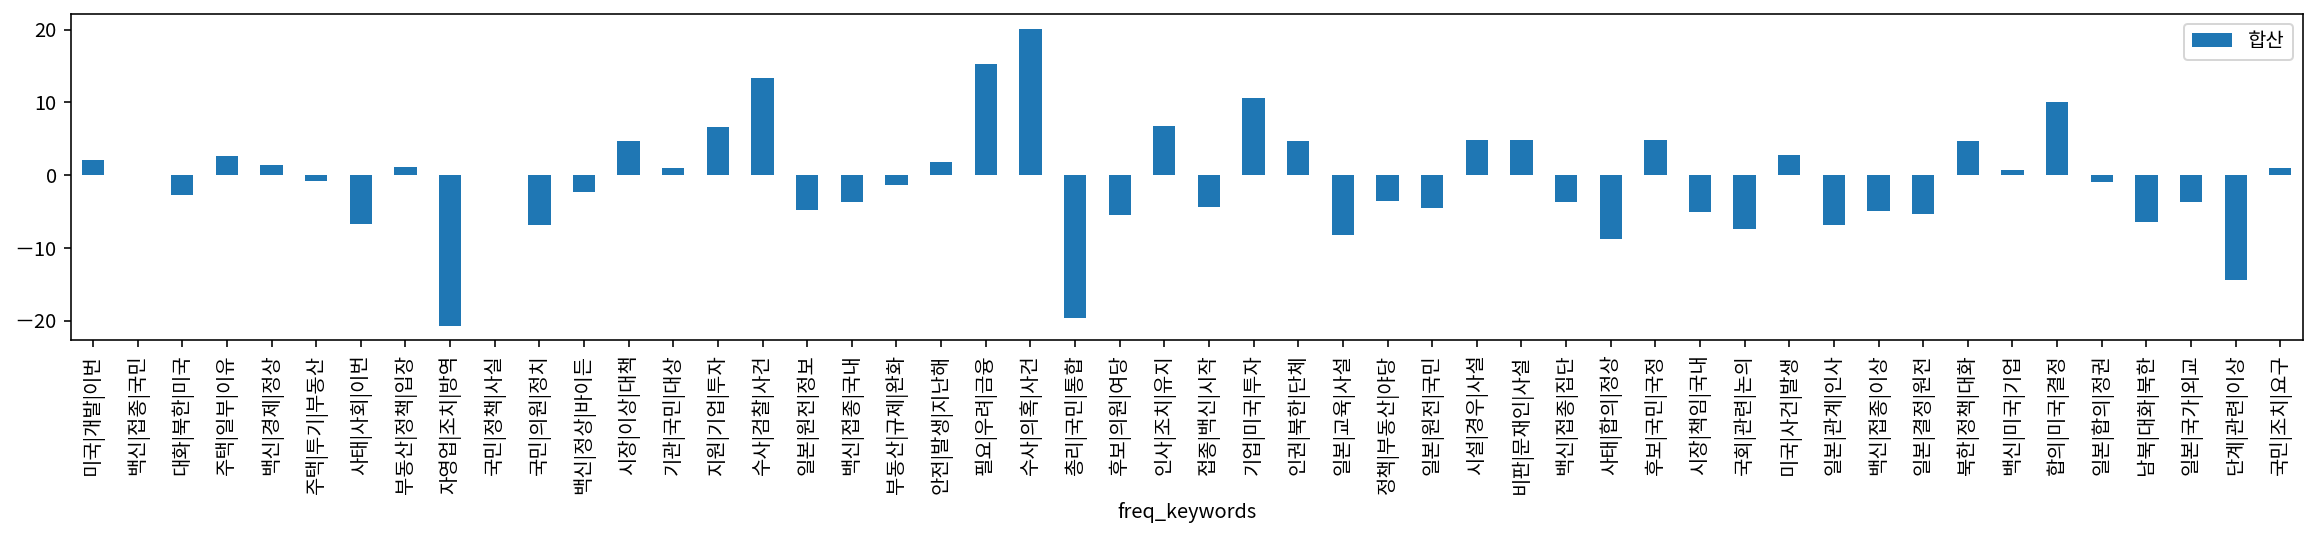

합산   -2.182048
dtype: float64


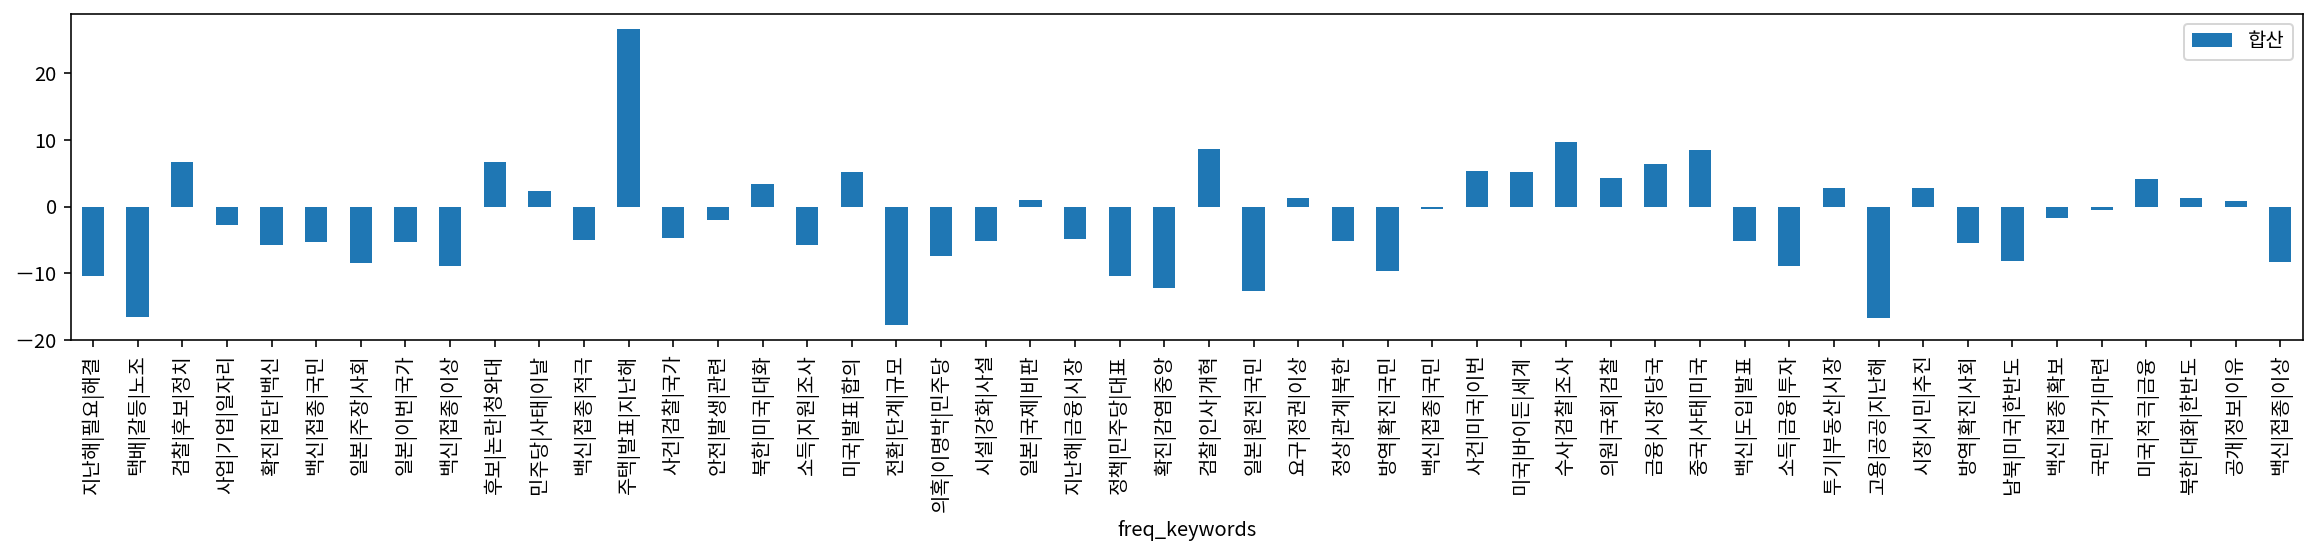

In [68]:
tmp = tmp[['freq_keywords','합산']].set_index('freq_keywords')
for i in range(0,100,50):
    tmp.iloc[i:i+50].plot.bar(figsize=(20,3))
    print(tmp.iloc[i:i+50].sum()/50)
    plt.show()

#### 보수 사설 분석

In [70]:
tmp = df_right_analysis.apply(cal_middle,axis=1)
tmp.columns=['freq_keywords','진보|명사|점수','보수|명사|점수','진보|bi|점수','보수|bi|점수','진보|tri|점수','보수|tri|점수','합산']
tmp

,freq_keywords,진보|명사|점수,보수|명사|점수,진보|bi|점수,보수|bi|점수,진보|tri|점수,보수|tri|점수,합산
0,수사|검찰|추진,72.323830,85.888221,1.029508,7.327138,0.000000,0.000000,19.862020
1,백신|국내|미국,75.669715,77.611222,2.242623,4.598513,0.000000,0.000000,4.297398
2,주택|민주당|방안,46.803120,51.064128,2.009836,7.338290,1.192982,6.480519,14.876999
3,대화|대북|외교,50.410436,49.504342,0.000000,0.000000,0.000000,0.000000,-0.906094
4,정상|관계|백신,67.394836,73.594077,11.304918,11.122677,1.000000,1.025974,6.042974
...,...,...,...,...,...,...,...,...
995,,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
996,,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
997,,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
998,,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [71]:
tmp.describe()

,진보|명사|점수,보수|명사|점수,진보|bi|점수,보수|bi|점수,진보|tri|점수,보수|tri|점수,합산
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,50.393897,52.426191,1.625702,2.247447,0.301593,0.433922,2.786368
std,31.364559,32.753667,2.586265,3.357762,0.881282,1.091758,8.009740
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-57.421900
25%,34.204008,36.069584,0.000000,0.000000,0.000000,0.000000,-0.791070
50%,53.645777,55.810510,1.003279,1.081784,0.000000,0.000000,1.198491
75%,69.841716,72.748553,2.219672,3.213755,0.000000,0.000000,6.853763
max,413.824637,475.461367,31.068852,44.118959,8.210526,15.597403,72.633162


합산    3.201243
dtype: float64


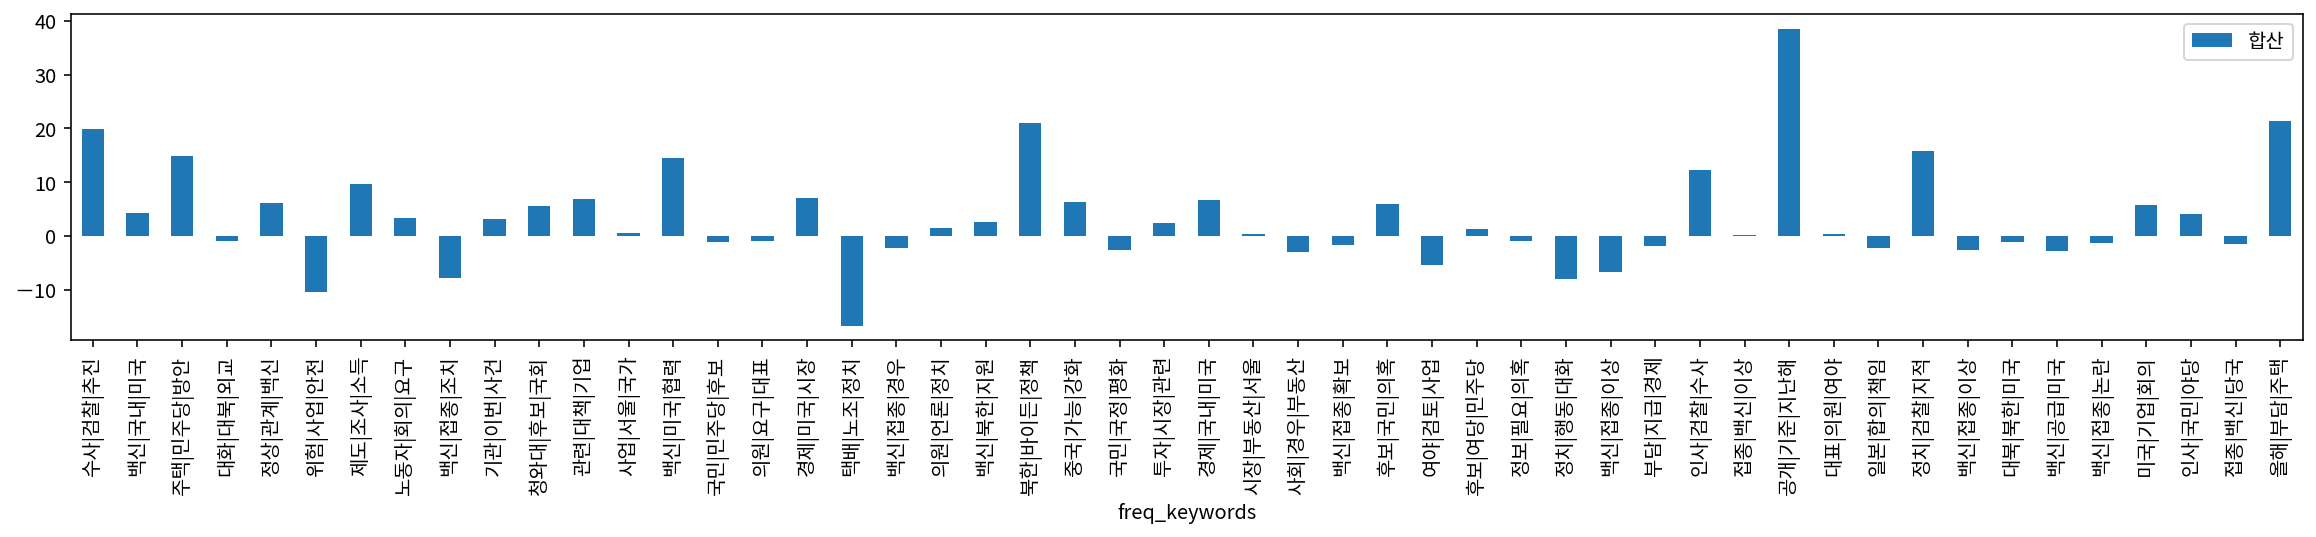

합산   -1.540236
dtype: float64


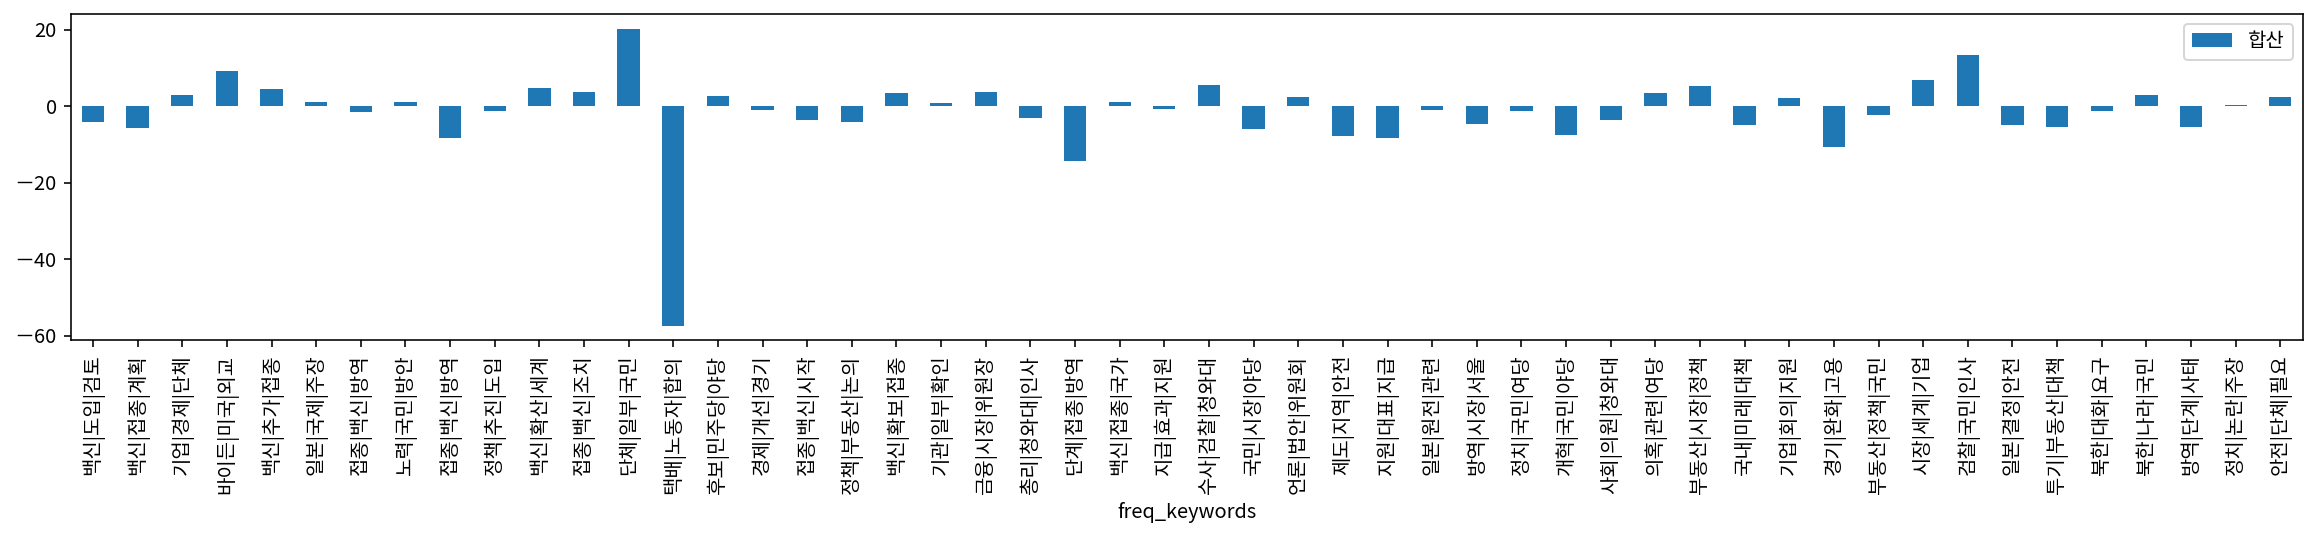

In [72]:
tmp = tmp[['freq_keywords','합산']].set_index('freq_keywords')

for i in range(0,100,50):
    tmp.iloc[i:i+50].plot.bar(figsize=(20,3))
    print(tmp.iloc[i:i+50].sum()/50)
    plt.show()

In [53]:
df_right[['국민일보|제목','국민일보|본문']].iloc[63:64]

,국민일보|제목,국민일보|본문
63,[사설] 노사·소비자 비용 분담으로 택배노동자 과로 개선해야,택배연대노조가 20일 총파업 찬반 투표에 들어갔다. 택배노동자 과로 환경 개선 방안...


#### 진보 사설 분석

In [73]:
tmp = df_left_analysis.apply(cal_middle,axis=1)
tmp.columns=['freq_keywords','진보|명사|점수','보수|명사|점수','진보|bi|점수','보수|bi|점수','진보|tri|점수','보수|tri|점수','합산']
tmp.describe()

,진보|명사|점수,보수|명사|점수,진보|bi|점수,보수|bi|점수,진보|tri|점수,보수|tri|점수,합산
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,71.706335,65.465741,4.720066,3.536894,0.712263,0.511279,-7.624749
std,30.388514,29.124327,4.876074,4.023791,1.482558,1.201781,11.404645
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-80.075877
25%,54.178994,48.583500,1.075410,1.000000,0.000000,0.000000,-13.190477
50%,69.363636,62.612670,3.273770,2.191450,0.000000,0.000000,-6.553410
75%,85.500941,78.828713,7.070492,5.280669,1.017544,0.000000,-0.656423
max,314.508338,294.431084,41.688525,33.739777,17.631579,13.428571,36.267826


합산   -8.215025
dtype: float64


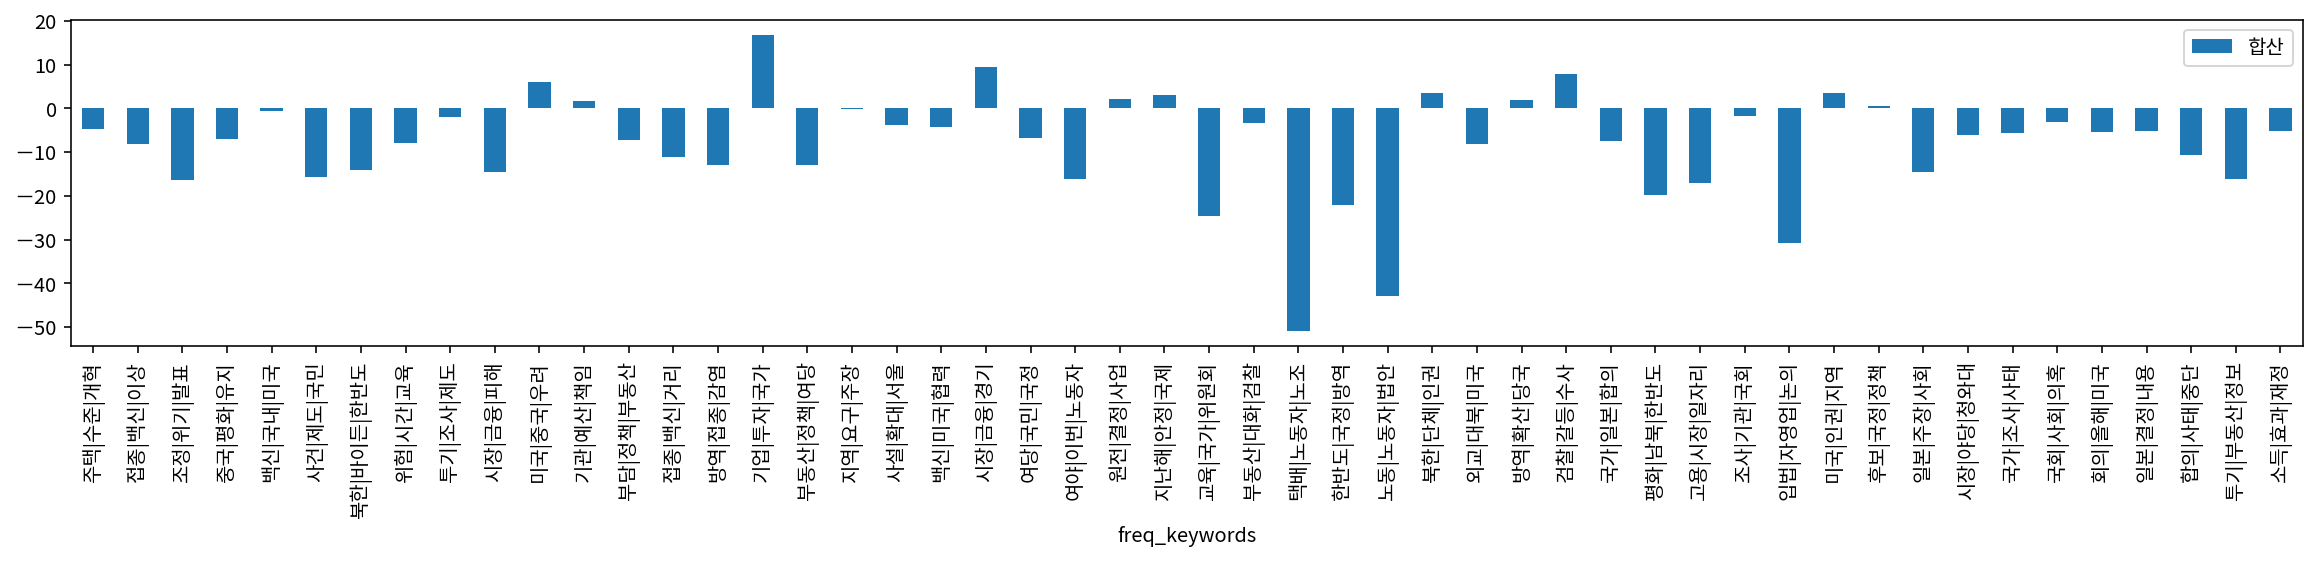

합산   -3.929714
dtype: float64


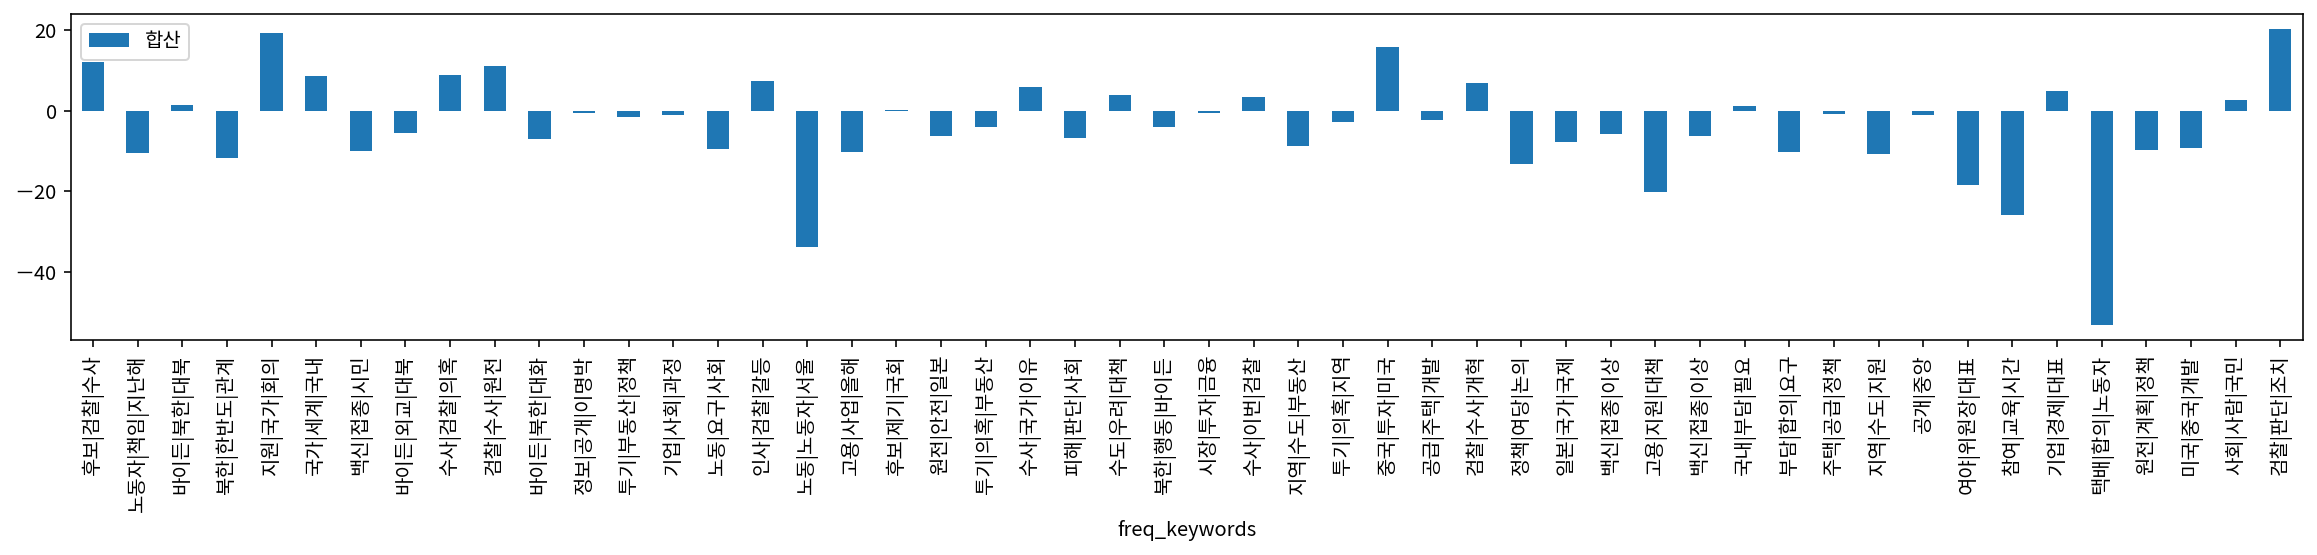

In [75]:
tmp = tmp[['freq_keywords','합산']].set_index('freq_keywords')

for i in range(0,100,50):
    tmp.iloc[i:i+50].plot.bar(figsize=(20,3))
    print(tmp.iloc[i:i+50].sum()/50)
    plt.show()

In [58]:
media_dict = {
    '경향신문':0,
    '한겨레':1,
    '국민일보': 2,
    '동아일보': 3,
    '문화일보': 4,
    '조선일보': 5,
    '중앙일보': 6,
    '서울신문':7,
    '천지일보':8,
    '한국일보':9
}
media_color = {
    '경향신문':'royalblue',
    '한겨레':'royalblue',
    '국민일보': 'orchid',
    '동아일보': 'orchid',
    '문화일보': 'orchid',
    '조선일보': 'orchid',
    '중앙일보': 'orchid',
    '서울신문': 'black',
    '천지일보': 'black',
    '한국일보': 'black'
}
mapping={
    '경향신문': 'kh.jpg',
     '한겨레': 'hgr.jpg',
     '국민일보': 'km.jpg',
     '동아일보': 'da.png',
     '문화일보': 'mh.jpg',
     '조선일보': 'js.jpg',
     '중앙일보': 'ja.jpg',
     '서울신문': 'su.jpg',
     '천지일보': 'cj.jpg',
     '한국일보': 'hg.jpg'
}

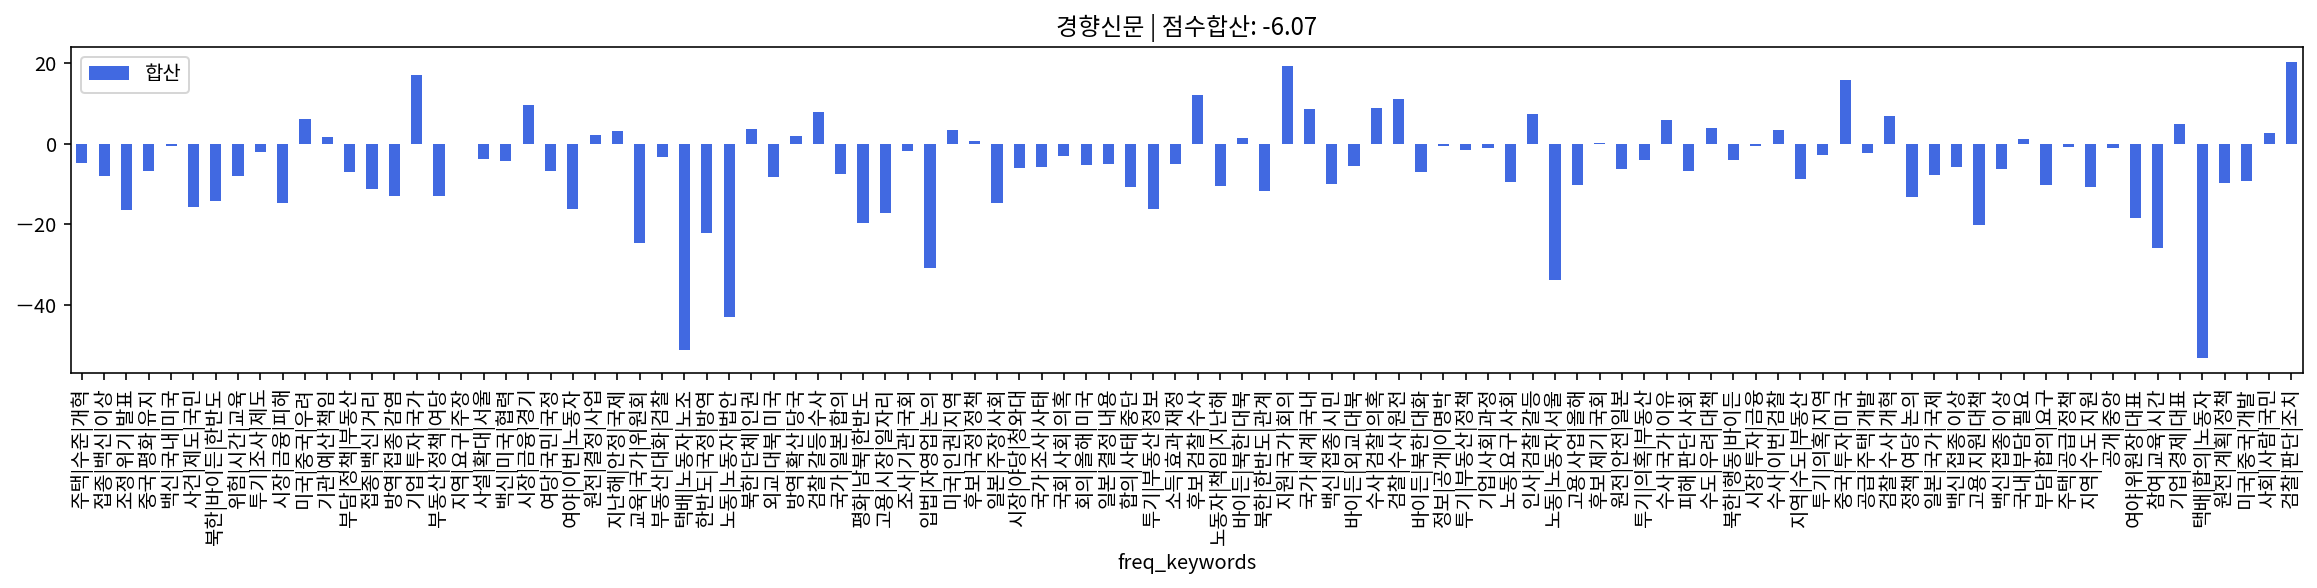

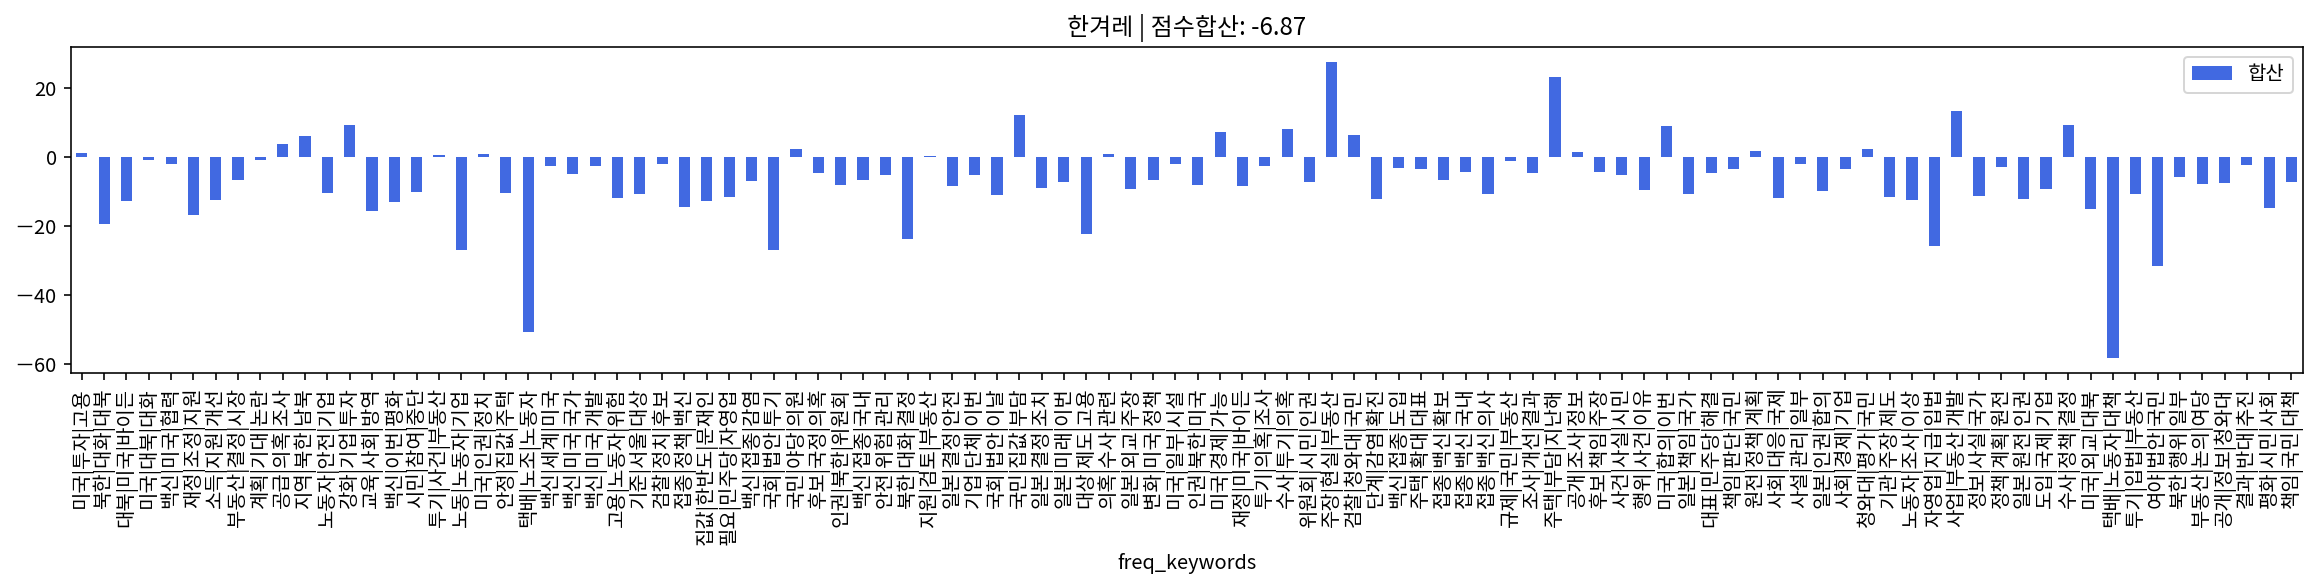

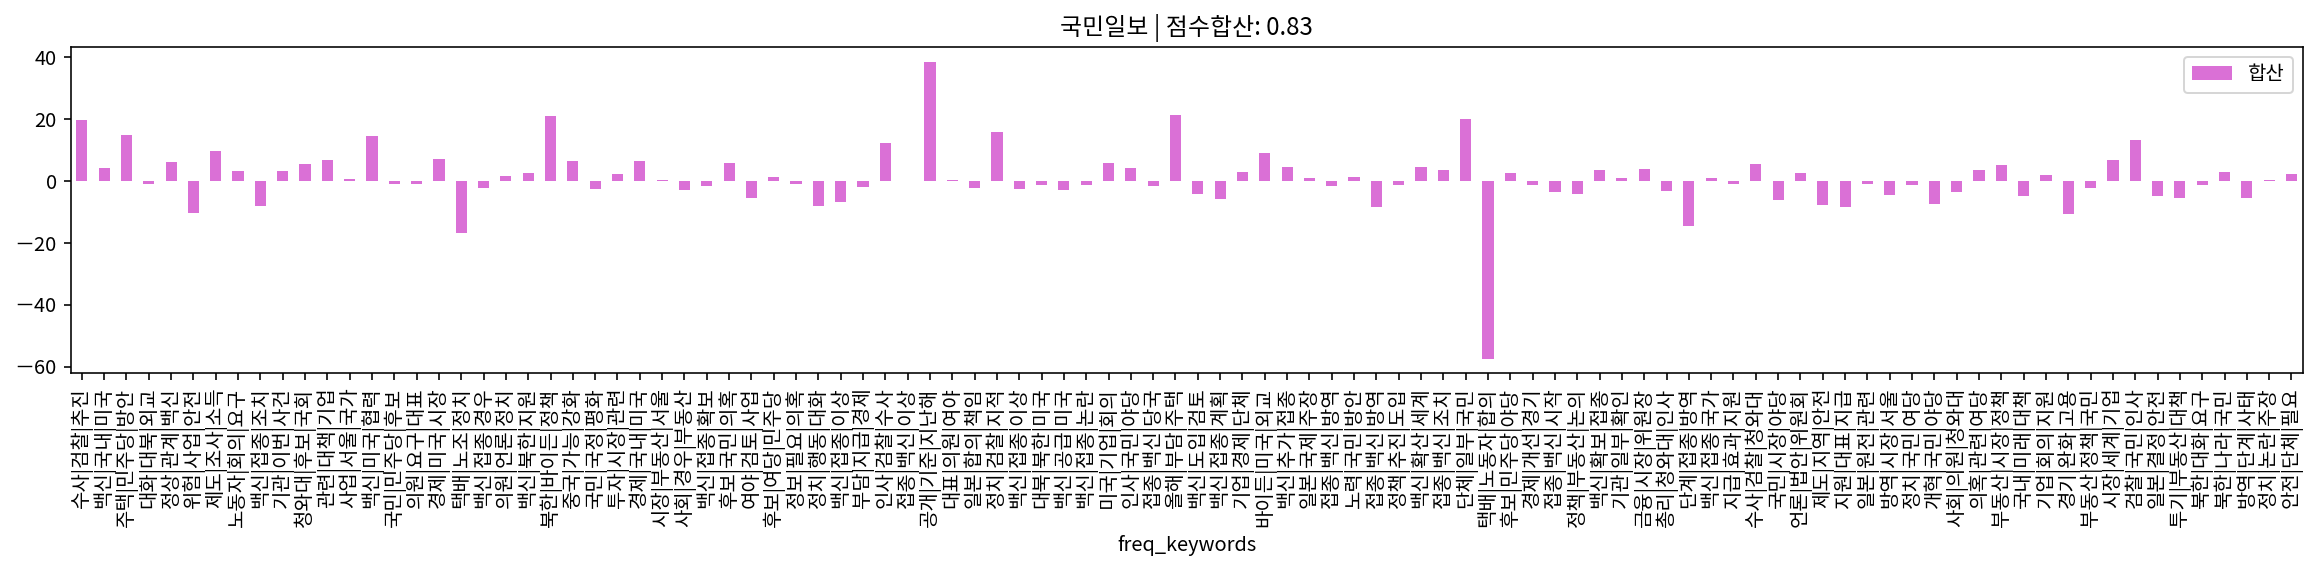

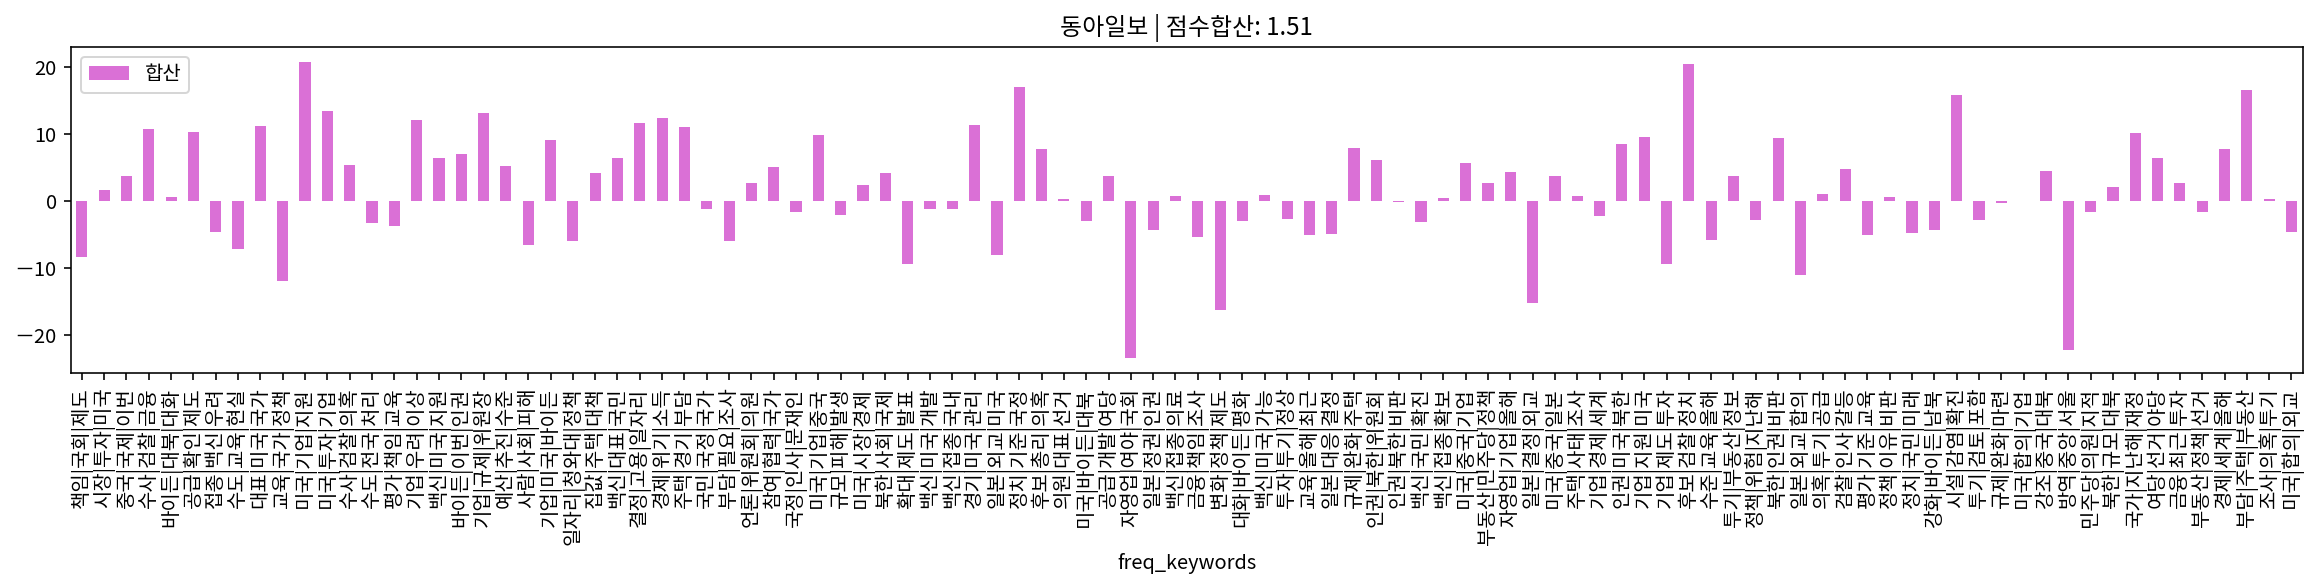

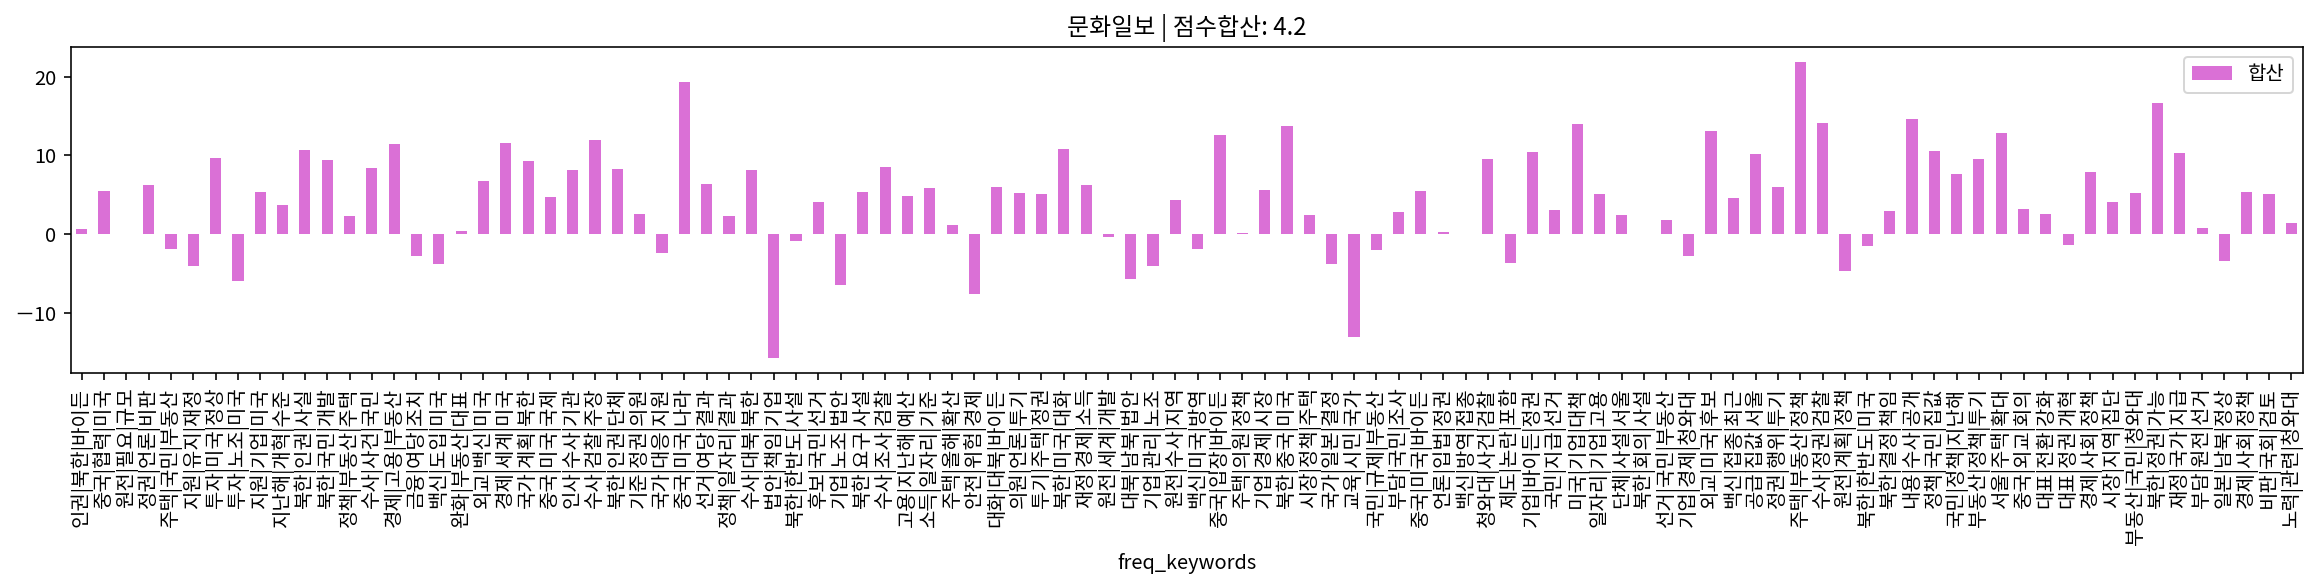

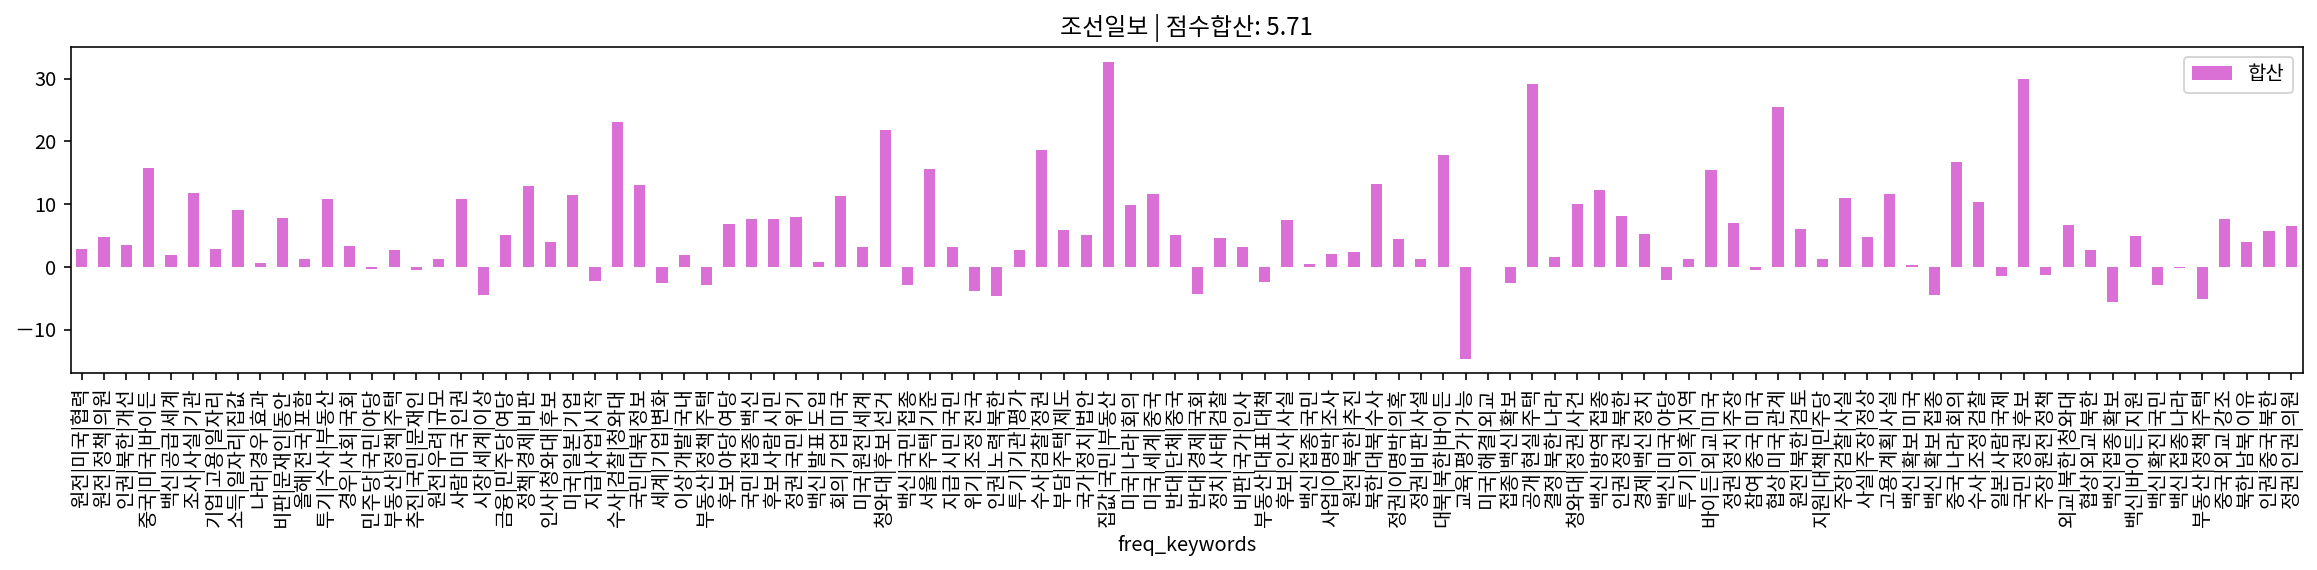

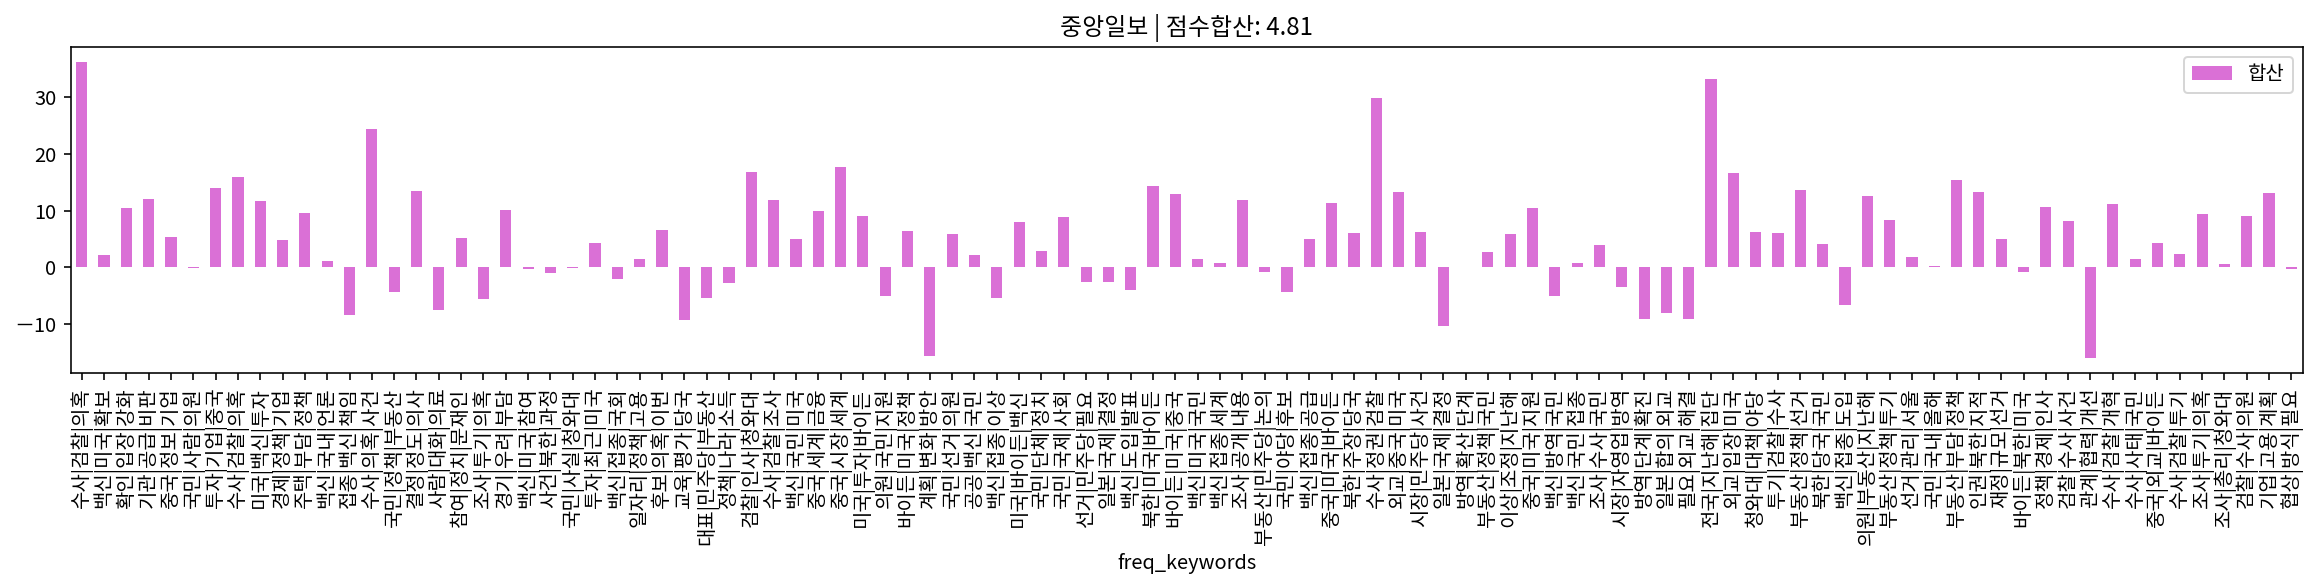

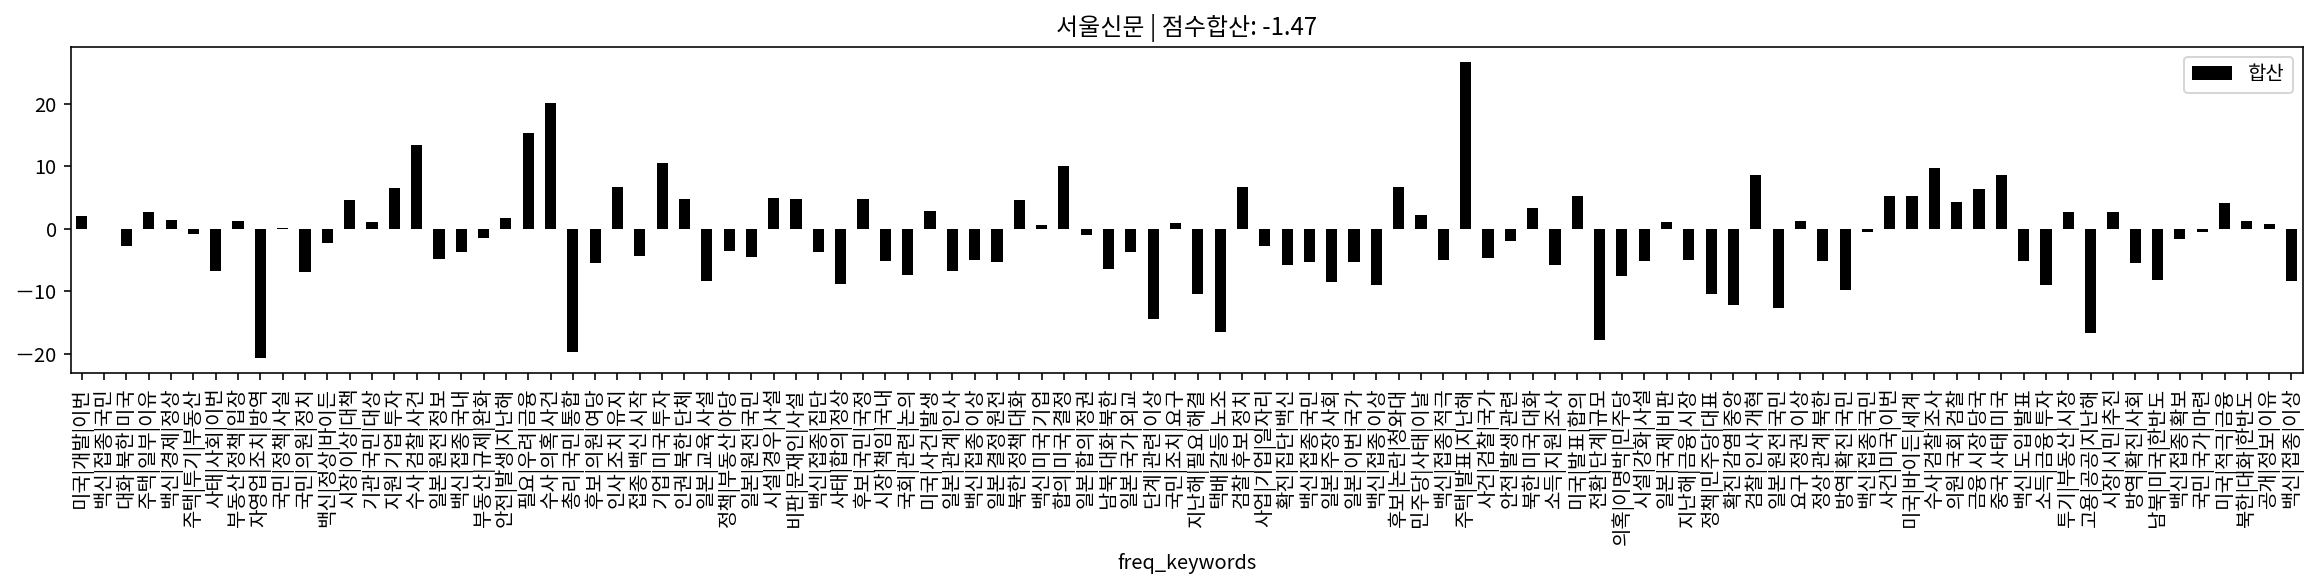

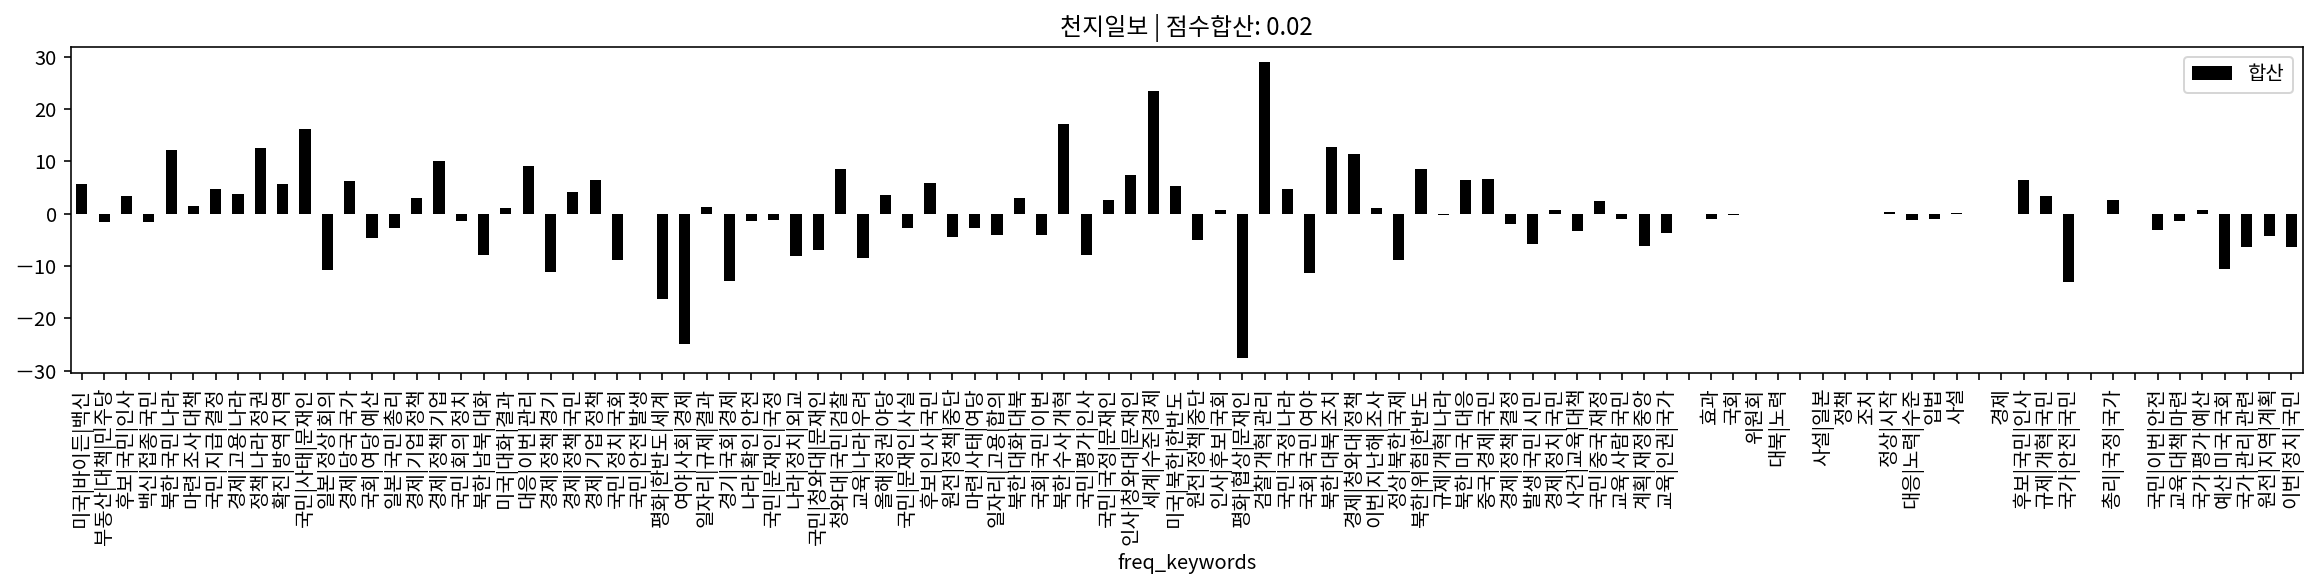

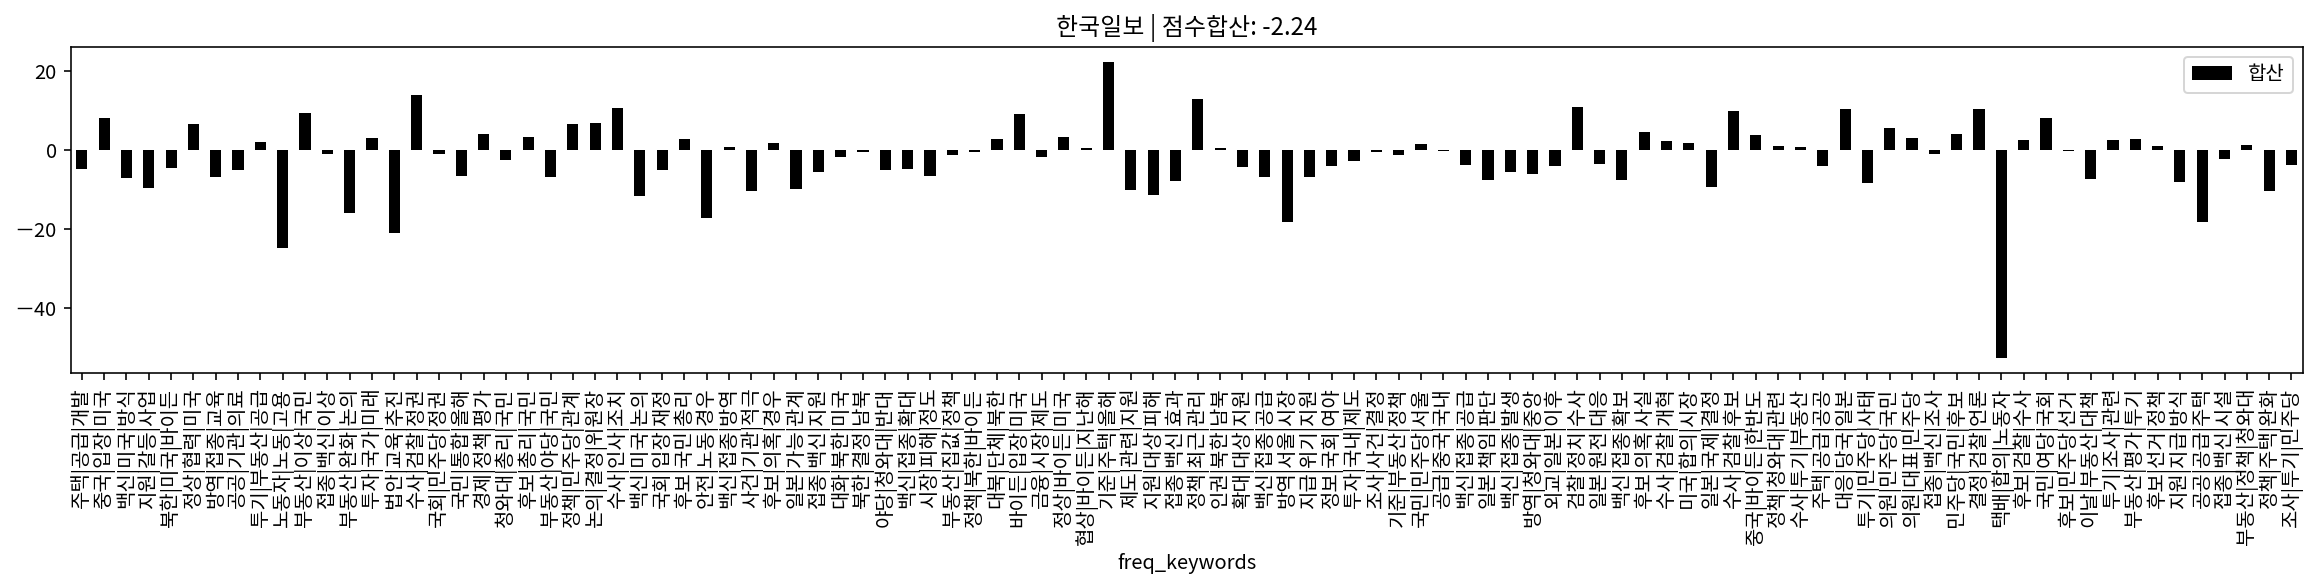

In [55]:
i=0
result_media_political_bias = {}
for ikey,ival in media_dict.items():
    tmp = pd.DataFrame(result_df[ival]).apply(cal_middle,axis=1)
    tmp.columns=['freq_keywords','진보|명사|점수','보수|명사|점수','진보|bi|점수','보수|bi|점수','진보|tri|점수','보수|tri|점수','합산']
    mean=round(tmp.iloc[i:i+100].describe()['합산']['mean'],2)
    tmp[['freq_keywords','합산']].set_index('freq_keywords').iloc[i:i+100].plot.bar(figsize=(20,3), color=media_color[ikey])
    result_media_political_bias[ikey]=mean
    plt.title('{} | 점수합산: {}'.format(ikey,mean))
    plt.show()

In [59]:
import cv2
from glob import glob
img_path = glob('./img/*')

In [60]:
result_media_political_bias

{'경향신문': -6.07,
 '한겨레': -6.87,
 '국민일보': 0.83,
 '동아일보': 1.51,
 '문화일보': 4.2,
 '조선일보': 5.71,
 '중앙일보': 4.81,
 '서울신문': -1.47,
 '천지일보': 0.02,
 '한국일보': -2.24}

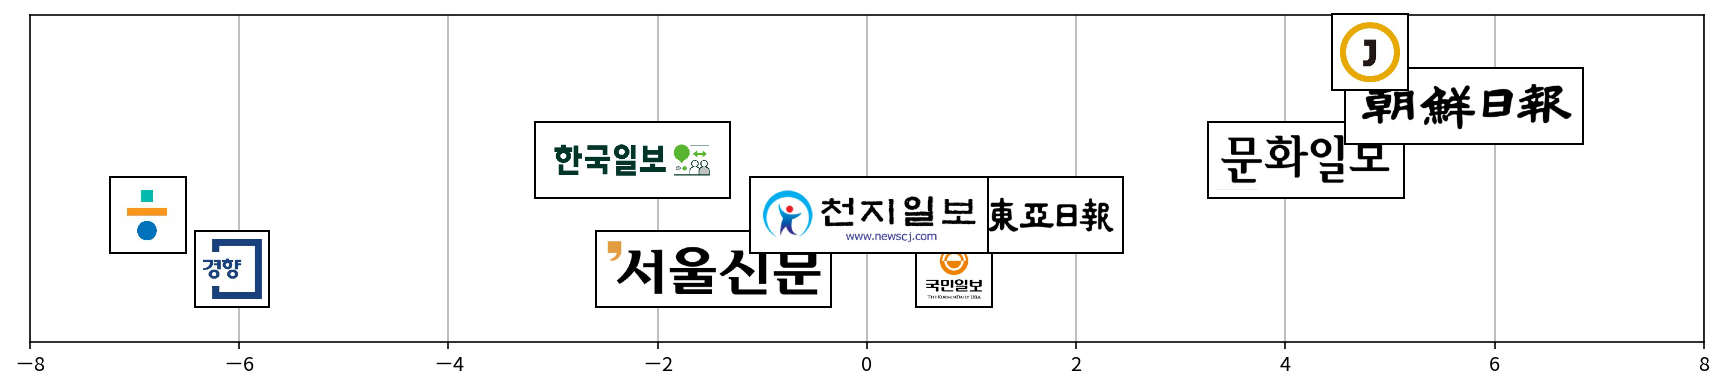

In [80]:
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
import matplotlib.image as mpimg

fig, ax = plt.subplots(figsize=(15,3))

ax.set_xlim(-8, 8)
ax.set_ylim(-1, 8)
ax.get_yaxis().set_visible(False)
plt.grid()
j=0
for ikey, ival in result_media_political_bias.items():
    arr_img = mpimg.imread("./img/{}".format(mapping[ikey]))
    imagebox = OffsetImage(arr_img, zoom=0.3)
    y = result_media_political_bias[ikey]
    ab = AnnotationBbox(imagebox, (y, 1+j))
    j+=1.5
    ax.add_artist(ab)
    if ikey=='한겨레':
        j=0
    if ikey=='중앙일보':
        j=0
    plt.draw()
plt.show()